# Intro & Problem Understanding

## Assurance of Learning Artificial Intelligence
Emas (XAU/USD) merupakan salah satu komoditas yang paling banyak diperdagangkan dan sangat dipengaruhi oleh volatilitas global, gejolak ekonomi, dan sentimen pasar. Memprediksi pergerakan harga emas secara akurat dapat memberikan keuntungan signifikan bagi trader dan investor.

Namun, harga emas sangat dinamis dan dipengaruhi oleh banyak faktor eksternal, sehingga metode prediksi konvensional sering kali tidak cukup. Oleh karena itu, dalam proyek ini kami menggunakan **Long Short-Term Memory (LSTM)** — model deep learning yang unggul dalam menangani data sequential seperti time series — untuk memprediksi harga emas berdasarkan data historis.

---

### 🎯 Tujuan
- Membangun model LSTM yang dapat memprediksi harga emas (XAU/USD) dengan akurasi tinggi.
- Menggunakan data historis harga emas selama **5 tahun terakhir (2020–2025)** dengan **timeframe H1 (hourly)**.
- Mengoptimalkan performa model menggunakan teknik seperti Dropout dan EarlyStopping untuk menghindari overfitting.
- Mengevaluasi performa model dengan visualisasi dan metrik regresi seperti RMSE dan R².
- Mengekspor model ke ONNX agar dapat digunakan dalam platform trading seperti **MetaTrader 5**.

---

### 🤖 Tools
- Python, TensorFlow/Keras
- MetaTrader 5 (untuk data collection)
- MinMaxScaler, Matplotlib
- ONNX (untuk deployment)

---

### 👥 Tim
| Nama                  | NIM        |
|-----------------------|------------|
| Muhammad Iqbal Saputra | 2702390236 |
| Angeline Delvin        | 2802526271 |
| Marvell Maxwell        | 2802472685 |

# Libraries

In [2]:
# 📦 Library Utama untuk Machine Learning & Deep Learning
import numpy as np                      # Untuk manipulasi array
import pandas as pd                    # Untuk manipulasi data tabular
import math                            # Untuk operasi matematika dasar

# 📊 Visualisasi
import matplotlib.pyplot as plt        # Untuk membuat grafik
import seaborn as sns # PASTIKAN INI ADA DI BAGIAN LIBRARIES Paling Atas Notebookmu!
import pandas as pd # Tambahkan jika belum terdefinisi di cell ini

# 🧠 TensorFlow & Keras
import tensorflow as tf                # Framework deep learning utama
from tensorflow.keras import backend as K  # Untuk operasi backend custom
from keras.models import Sequential    # Untuk membuat model sekuensial
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D  # (opsional) untuk model hybrid CNN-LSTM
from keras.metrics import RootMeanSquaredError as rmse
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model  # Untuk visualisasi arsitektur model
from keras import optimizers                # Untuk kustomisasi optimizer

# 📁 Data Collection dari MetaTrader 5
import MetaTrader5 as mt5              # Untuk mengakses data harga dari MT5

# 📅 Tanggal dan Waktu
from datetime import datetime, timedelta  # Untuk range tanggal
import time                               # Untuk tracking durasi training

# ⚙️ Utility
from sklearn.model_selection import train_test_split  # Untuk membagi data train/test
from sklearn.preprocessing import MinMaxScaler        # Untuk normalisasi data
import tf2onnx                                        # Untuk konversi model ke format ONNX
from sys import argv                                  # Untuk akses argument command line (opsional)
import gc                                             # Untuk garbage collection (mengurangi memory leak)

# 🔧 Pengaturan Awal
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
# Cek versi TensorFlow
print(f"Versi TensorFlow:",tf.__version__)

# Cek apakah GPU tersedia
if tf.config.list_physical_devices('GPU'):
    print("GPU tersedia")
else:
    print("GPU tidak tersedia, menggunakan CPU")
    
gpu_device = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPU = {len(gpu_device)}")
tf.config.experimental.set_memory_growth(gpu_device[0], True)

Versi TensorFlow: 2.10.0
GPU tersedia
Number of GPU = 1


# Data Collection

In [4]:
# Menginisialisasi koneksi ke MetaTrader5
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
    
# Show terminal info
terminal_info=mt5.terminal_info()
print(terminal_info)


TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=True, trade_allowed=True, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=True, build=4885, maxbars=100000, codepage=0, ping_last=24951, community_balance=0.0, retransmission=1.498175892146151, company='MetaQuotes Ltd.', name='MetaTrader 5', language='English', path='C:\\Program Files\\MetaTrader 5', data_path='C:\\Users\\miqba\\AppData\\Roaming\\MetaQuotes\\Terminal\\D0E8209F77C8CF37AD8BF550E51FF075', commondata_path='C:\\Users\\miqba\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')


In [5]:
# Define start and end dates for data collection
end_date = datetime.now()
start_date = end_date - timedelta(days=180)
# start_date = datetime(2025, 1, 1) # Mulai dari 1 Januari 2020

# Cek apakah tanggal mulai lebih awal dari tanggal akhir
print("data start date =",start_date)
print("data end date =",end_date)

data start date = 2024-12-04 14:25:35.034080
data end date = 2025-06-02 14:25:35.034080


In [6]:
# end_date = datetime.now()
# start_date = end_date - timedelta(days=120)

# #print start and end dates
# print("data start date=",start_date)
# print("data end date=",end_date)

In [7]:
# Ambil data harga XAUUSD (Timeframe H1) dari MT5
xauusd_rates = mt5.copy_rates_range("XAUUSD", mt5.TIMEFRAME_M15, start_date, end_date)

In [8]:


# Bikin DataFrame dari data yang diambil
df = pd.DataFrame(xauusd_rates)
df['time'] = pd.to_datetime(df['time'], unit='s') # Ubah timestamp ke datetime
df.set_index('time', inplace=True)

# Cek beberapa baris awal dan akhir DataFrame
print("\nDataFrame Head:")
print(df.head())
print("\nDataFrame Tail:")
print(df.tail())
print(f"\nDataFrame Shape: {df.shape}") # Liat berapa banyak data (rows, columns)


DataFrame Head:
                         open      high       low     close  tick_volume  \
time                                                                       
2024-12-04 07:30:00  2644.913  2644.995  2640.508  2641.110         1854   
2024-12-04 07:45:00  2641.107  2642.185  2640.358  2641.377         1891   
2024-12-04 08:00:00  2641.345  2642.204  2639.525  2639.798         2104   
2024-12-04 08:15:00  2639.835  2640.930  2637.778  2638.879         1942   
2024-12-04 08:30:00  2638.927  2640.483  2636.614  2640.265         2214   

                     spread  real_volume  
time                                      
2024-12-04 07:30:00     111            0  
2024-12-04 07:45:00     112            0  
2024-12-04 08:00:00     112            0  
2024-12-04 08:15:00     111            0  
2024-12-04 08:30:00     111            0  

DataFrame Tail:
                         open      high       low     close  tick_volume  \
time                                                    

In [9]:
# Simpan data ke CSV
df.to_csv("XAUUSD_H1_DATA.csv", index=False)  

In [10]:
# Define DataFrame untuk XAUUSD rates
df = pd.DataFrame(xauusd_rates)

# Cek beberapa baris awal DataFrame
df.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,1733297400,2644.913,2644.995,2640.508,2641.110,1854,111,0
1,1733298300,2641.107,2642.185,2640.358,2641.377,1891,112,0
2,1733299200,2641.345,2642.204,2639.525,2639.798,2104,112,0
3,1733300100,2639.835,2640.930,2637.778,2638.879,1942,111,0
4,1733301000,2638.927,2640.483,2636.614,2640.265,2214,111,0


In [11]:
# Cek beberapa baris akhir DataFrame
df.tail()

,time,open,high,low,close,tick_volume,spread,real_volume
11448,1748844900,3328.045,3338.093,3327.668,3337.519,3585,111,0
11449,1748845800,3337.516,3345.173,3335.880,3345.173,3738,111,0
11450,1748846700,3345.101,3345.490,3340.008,3344.482,3106,111,0
11451,1748847600,3344.509,3352.779,3343.159,3351.246,4102,111,0
11452,1748848500,3351.214,3358.617,3351.214,3357.980,3315,111,0


In [12]:
# Cek bentuk DataFrame
df.shape

(11453, 8)

# Exploratory Data Analysis

In [13]:
# Cek deskripsi statistik dari DataFrame
df.describe()

,time,open,high,low,close,tick_volume,spread,real_volume
count,1.145300e+04,11453.000000,11453.000000,11453.000000,11453.000000,11453.000000,11453.000000,11453.0
mean,1.741098e+09,2964.072640,2966.369086,2961.727194,2964.134881,2747.933118,111.721208,0.0
std,4.449544e+06,249.483427,250.234088,248.681862,249.499345,2021.419829,8.020455,0.0
min,1.733297e+09,2583.965000,2588.359000,2583.426000,2585.979000,62.000000,44.000000,0.0
25%,1.737383e+09,2718.115000,2719.403000,2716.533000,2718.094000,1503.000000,111.000000,0.0
50%,1.741132e+09,2925.847000,2928.243000,2923.447000,2925.960000,2187.000000,111.000000,0.0
75%,1.744853e+09,3221.059000,3224.168000,3217.602000,3221.125000,3326.000000,112.000000,0.0
max,1.748848e+09,3497.487000,3500.057000,3488.975000,3497.531000,22601.000000,335.000000,0.0


In [14]:
# Cek info dari DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11453 entries, 0 to 11452
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         11453 non-null  int64  
 1   open         11453 non-null  float64
 2   high         11453 non-null  float64
 3   low          11453 non-null  float64
 4   close        11453 non-null  float64
 5   tick_volume  11453 non-null  uint64 
 6   spread       11453 non-null  int32  
 7   real_volume  11453 non-null  uint64 
dtypes: float64(4), int32(1), int64(1), uint64(2)
memory usage: 671.2 KB


In [15]:
df.isnull().sum()  # Cek apakah ada nilai yang hilang (NaN)

time           0
open           0
high           0
low            0
close          0
tick_volume    0
spread         0
real_volume    0
dtype: int64

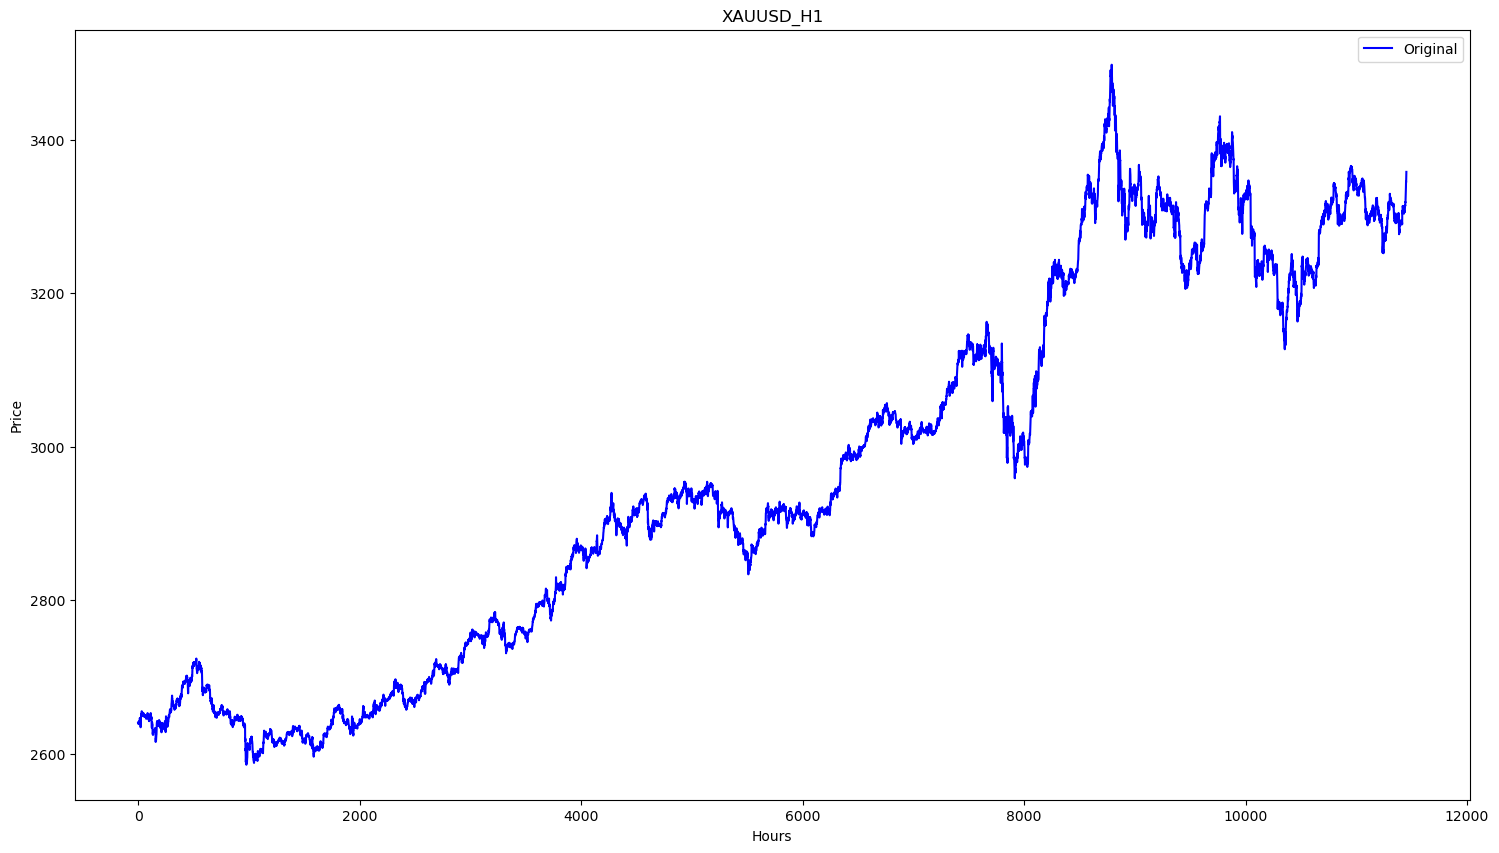

In [16]:
# Tampilkan beberapa informasi dasar tentang DataFrame
plt.figure(figsize = (18,10))
plt.plot(df['close'],'b',label = 'Original')
plt.xlabel("Hours")
plt.ylabel("Price")
plt.title("XAUUSD_H1")
plt.legend()

In [17]:
# 2.2. Cek Duplikasi pada Indeks Waktu
print("\n--- Cek Duplikasi pada Indeks Waktu ---")
duplicates = df.index.duplicated().sum()
if duplicates > 0:
    print(f"Ditemukan {duplicates} duplikasi pada indeks waktu.")
    # Opsional: df = df[~df.index.duplicated(keep='first')] jika ingin menghapus duplikasi
else:
    print("Tidak ditemukan duplikasi pada indeks waktu.")


--- Cek Duplikasi pada Indeks Waktu ---
Tidak ditemukan duplikasi pada indeks waktu.


In [18]:
# Asumsikan df sudah tersedia dan kolom 'time' sudah menjadi DatetimeIndex dari cell sebelumnya
# Contohnya, dari kode di cell 7 pada Vord.ipynb

import numpy as np # Pastikan numpy terimport untuk np.isclose

# --- 2.3. Cek Jeda Waktu (Gaps) pada Data H1 (Pendekatan Pragmatis) ---
print("\n--- Cek Jeda Waktu (Gaps) pada Data H1 (Pendekatan Pragmatis) ---")

# Menghitung selisih waktu antar baris
time_diff = df.index.to_series().diff()

# Memastikan time_diff adalah tipe timedelta64[ns]
time_diff = time_diff.astype('timedelta64[ns]')

# Lalu menghitung selisih dalam jam (float)
time_diff_hours = time_diff.dt.total_seconds() / 3600

# Kita akan menganggap "interval normal" jika selisihnya sangat dekat dengan 1 jam.
# Misalnya, dalam rentang (1 - 0.0001) sampai (1 + 0.0001) jam, yaitu toleransi +/- 0.36 detik
TOLERANCE_FOR_NORMAL_INTERVAL = 0.0001 # dalam jam

# Identifikasi gap yang signifikan: yaitu interval yang TIDAK mendekati 1 jam DAN TIDAK mendekati 0 jam.
# Yang mendekati 0 jam kita asumsikan duplikasi (sudah dicek, tapi ini untuk jaga-jaga).
# Yang mendekati 1 jam kita anggap normal.
# Jadi, kita mencari yang `time_diff_hours` nya bukan di antara (1 - TOLERANCE) dan (1 + TOLERANCE),
# DAN juga bukan di antara (-TOLERANCE) dan (+TOLERANCE) untuk 0.
significant_gaps = time_diff_hours[
    (time_diff_hours < (1.0 - TOLERANCE_FOR_NORMAL_INTERVAL)) |
    (time_diff_hours > (1.0 + TOLERANCE_FOR_NORMAL_INTERVAL))
].dropna()

# Tambahkan kondisi untuk menghilangkan selisih yang sangat kecil tapi positif (yang sebelumnya 2.77e-13)
# Kita hanya ingin gap yang nilainya signifikan (misal > 1.5 jam atau < 0.5 jam, dll.)
# Ini bisa disesuaikan, tapi mari kita coba filter yang sangat kecil.
significant_gaps = significant_gaps[significant_gaps.abs() > 0.001].dropna() # Anggap gap jika lebih dari 0.001 jam (3.6 detik)

if not significant_gaps.empty:
    print(f"Ditemukan {len(significant_gaps)} gap/anomali waktu yang signifikan di data. Berikut adalah beberapa di antaranya (dalam jam):")
    print(significant_gaps.head(10)) # Tampilkan 10 contoh gap

    print("\nPenting: Gap/anomali ini sangat mungkin terjadi karena pasar tutup (weekend, libur nasional, dll.).")

else:
    print("Tidak ditemukan gap/anomali waktu yang signifikan di data (selain jeda pasar yang normal atau perbedaan presisi waktu yang sangat kecil).")


--- Cek Jeda Waktu (Gaps) pada Data H1 (Pendekatan Pragmatis) ---
Tidak ditemukan gap/anomali waktu yang signifikan di data (selain jeda pasar yang normal atau perbedaan presisi waktu yang sangat kecil).


In [19]:

# Drop 'real_volume' column seperti yang sudah kita sepakati (jika belum didrop)
# VORD menyarankan ini ditaruh setelah df = pd.DataFrame(xauusd_rates) di bagian Data Collection.
# Tapi untuk memastikan, kita cek lagi di sini.
if 'real_volume' in df.columns:
    if df['real_volume'].sum() == 0: # Pastikan memang semua valuenya 0 sebelum drop
        df_eda = df.drop(columns=['real_volume'])
        print("\nKolom 'real_volume' telah di-drop untuk tujuan EDA (karena semua nilainya 0).")
    else:
        df_eda = df.copy() # Jika ada nilai non-nol, jangan drop, cukup copy
        print("\nKolom 'real_volume' memiliki nilai, tidak di-drop untuk EDA.")
else:
    df_eda = df.copy() # Jika kolom tidak ada, cukup buat copy untuk EDA



Kolom 'real_volume' telah di-drop untuk tujuan EDA (karena semua nilainya 0).



--- 3. Visualisasi Mendalam ---

--- 3.1. Plot Garis Individual untuk Setiap Fitur ---


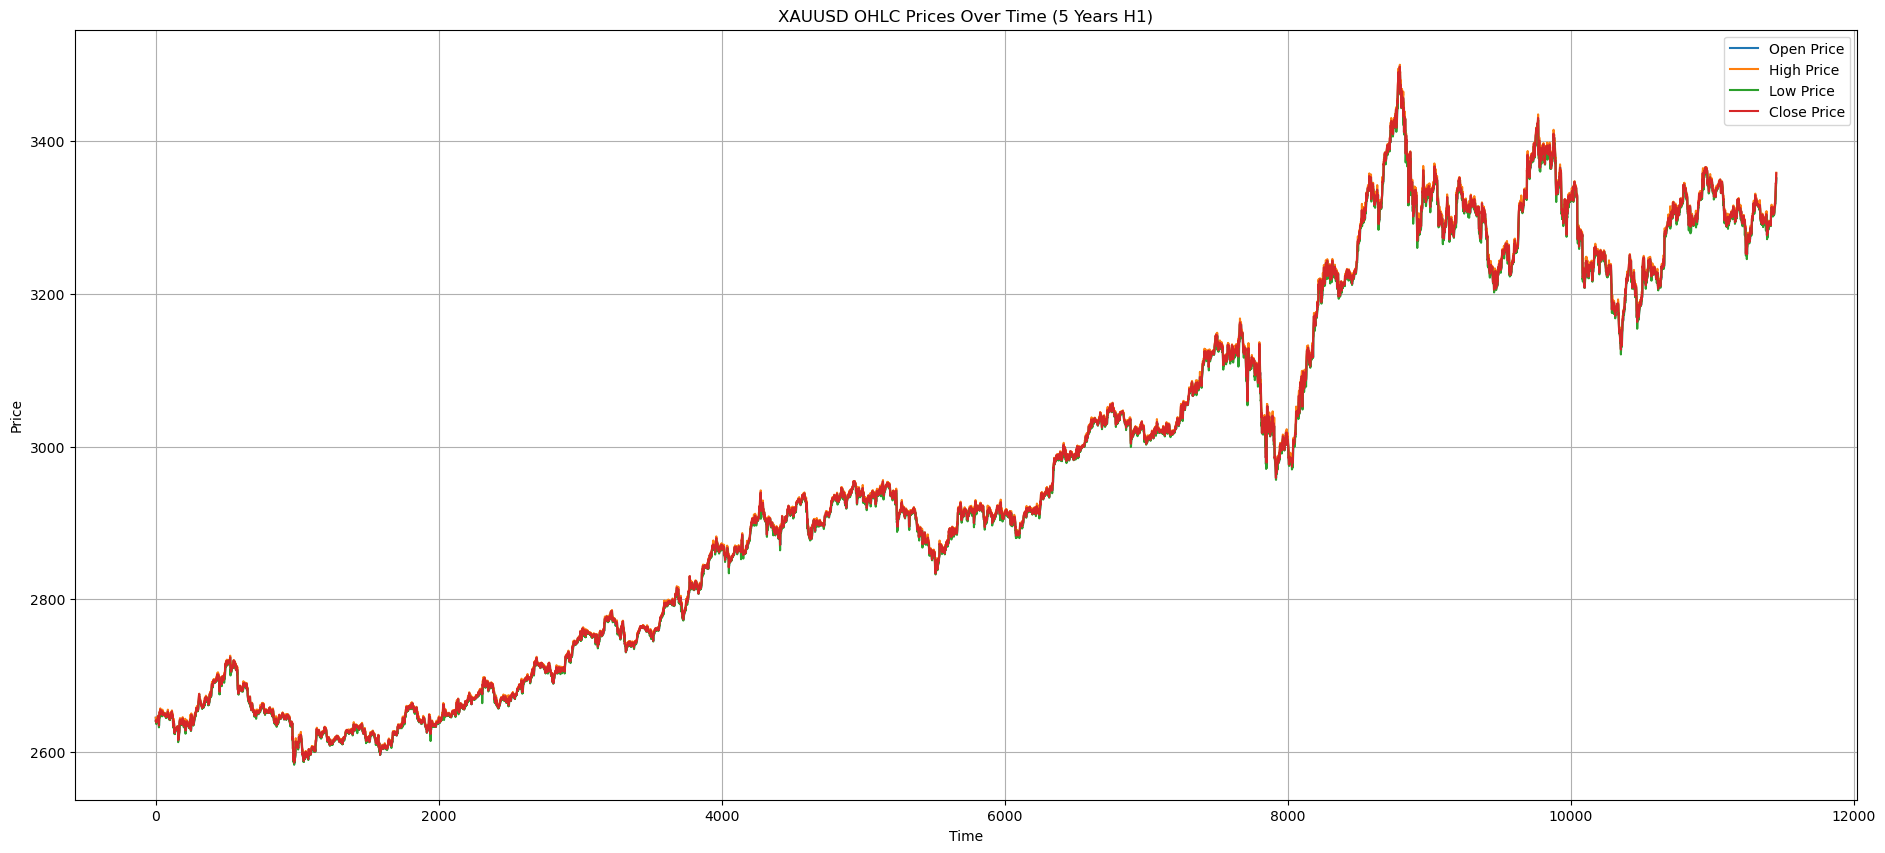

In [20]:

print("\n--- 3. Visualisasi Mendalam ---")

# 3.1. Plot Garis Individual untuk Setiap Fitur (Harga & Volume/Spread)
print("\n--- 3.1. Plot Garis Individual untuk Setiap Fitur ---")

# Plot Harga (OHLC) dalam satu grafik
plt.figure(figsize=(23, 10))
plt.plot(df_eda['open'], label='Open Price')
plt.plot(df_eda['high'], label='High Price')
plt.plot(df_eda['low'], label='Low Price')
plt.plot(df_eda['close'], label='Close Price')
plt.title('XAUUSD OHLC Prices Over Time (5 Years H1)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

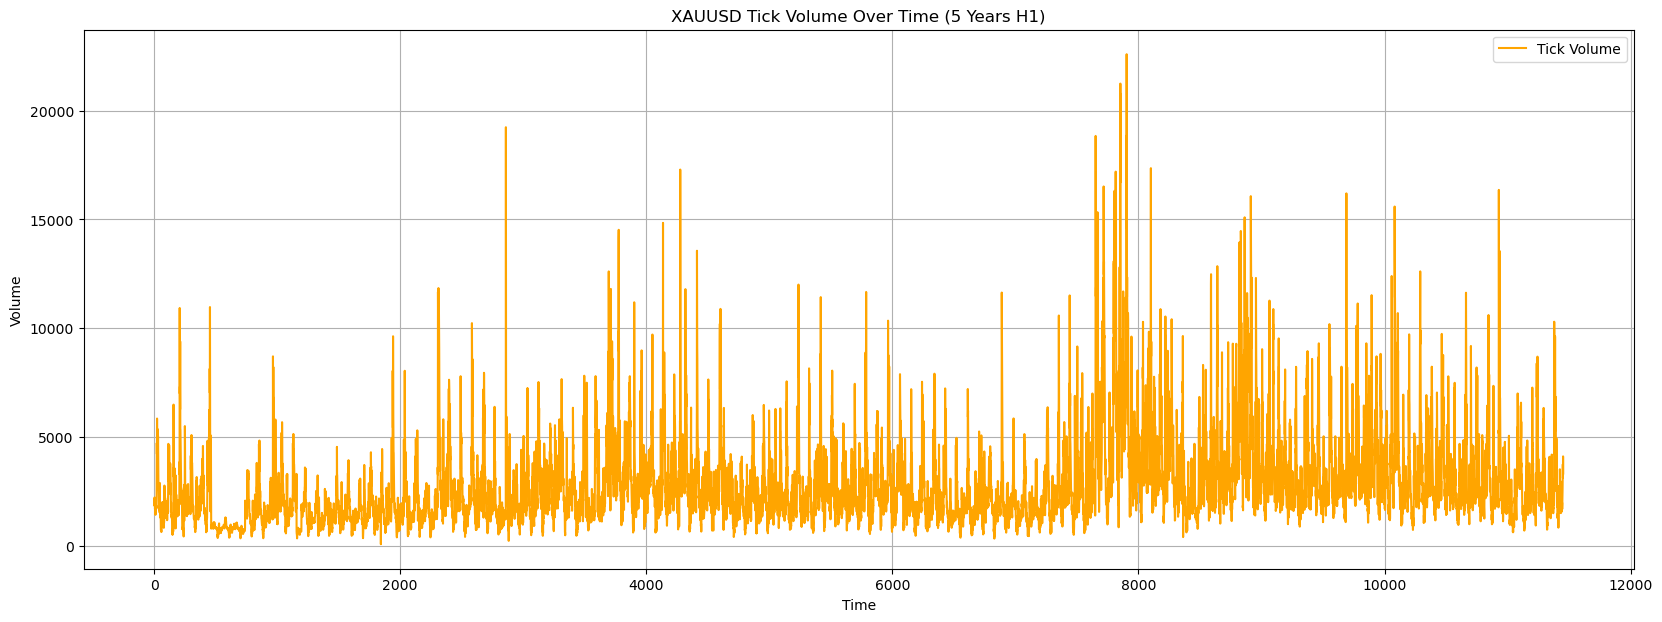

In [21]:

# Plot Tick Volume
plt.figure(figsize=(20, 7))
plt.plot(df_eda['tick_volume'], label='Tick Volume', color='orange')
plt.title('XAUUSD Tick Volume Over Time (5 Years H1)')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

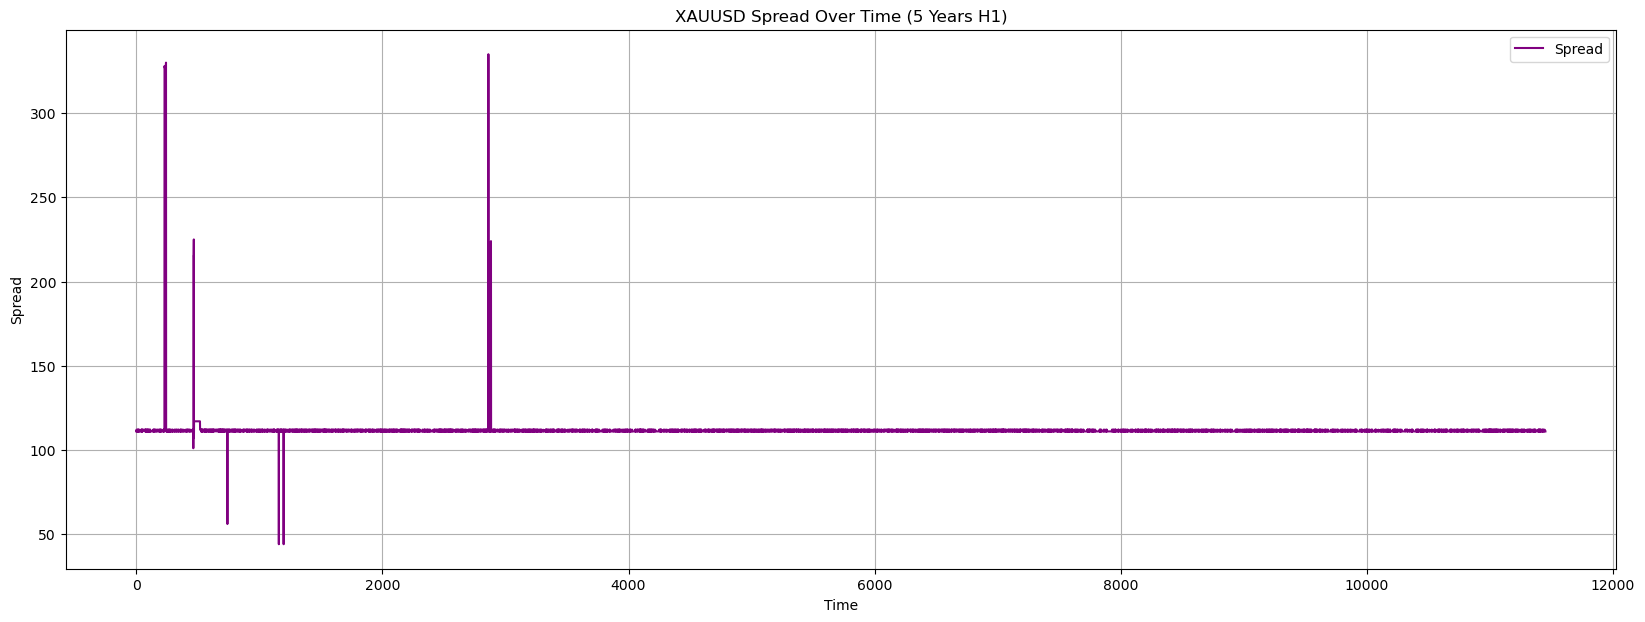

In [22]:
# Plot Spread
plt.figure(figsize=(20, 7))
plt.plot(df_eda['spread'], label='Spread', color='purple')
plt.title('XAUUSD Spread Over Time (5 Years H1)')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()


--- 3.2. Histogram dan Box Plot untuk Setiap Fitur Numerik ---


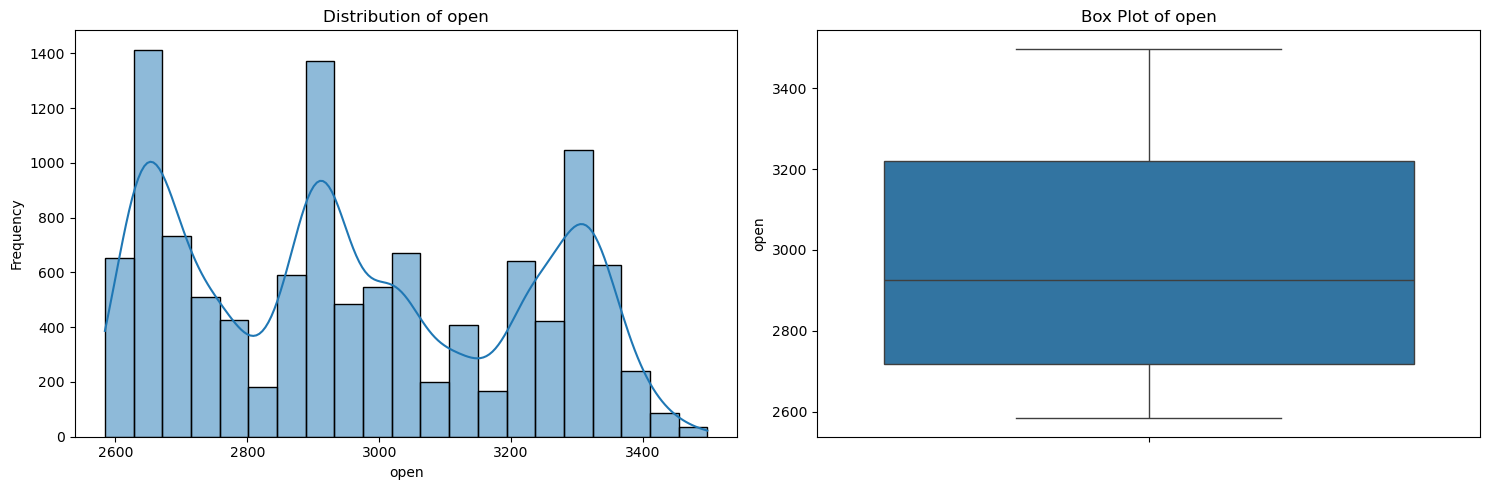

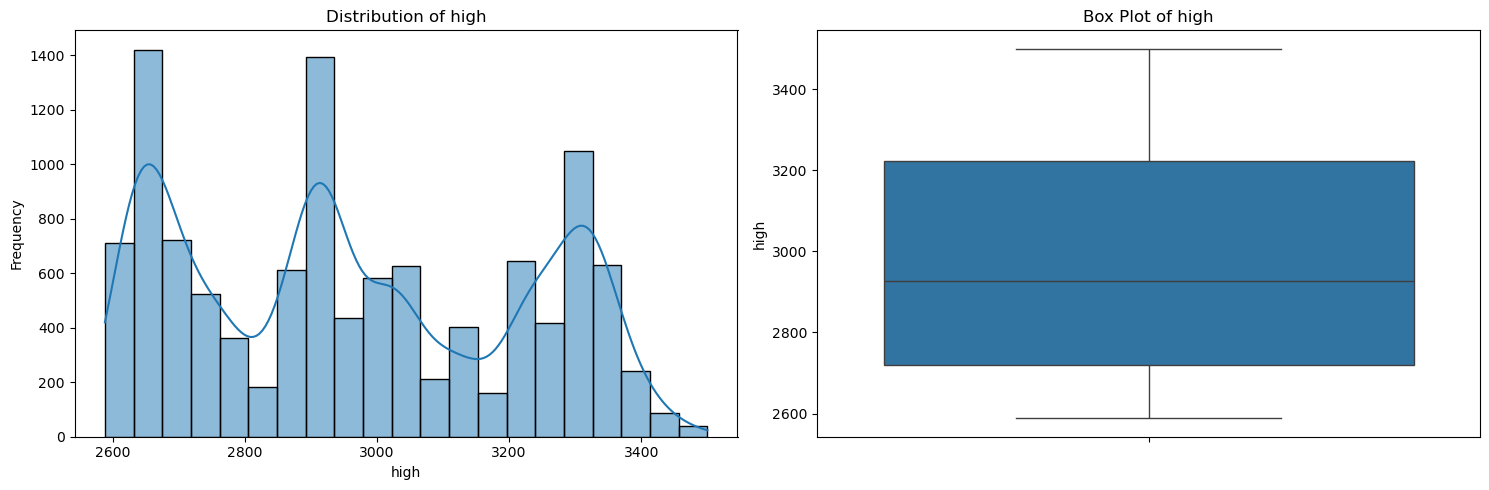

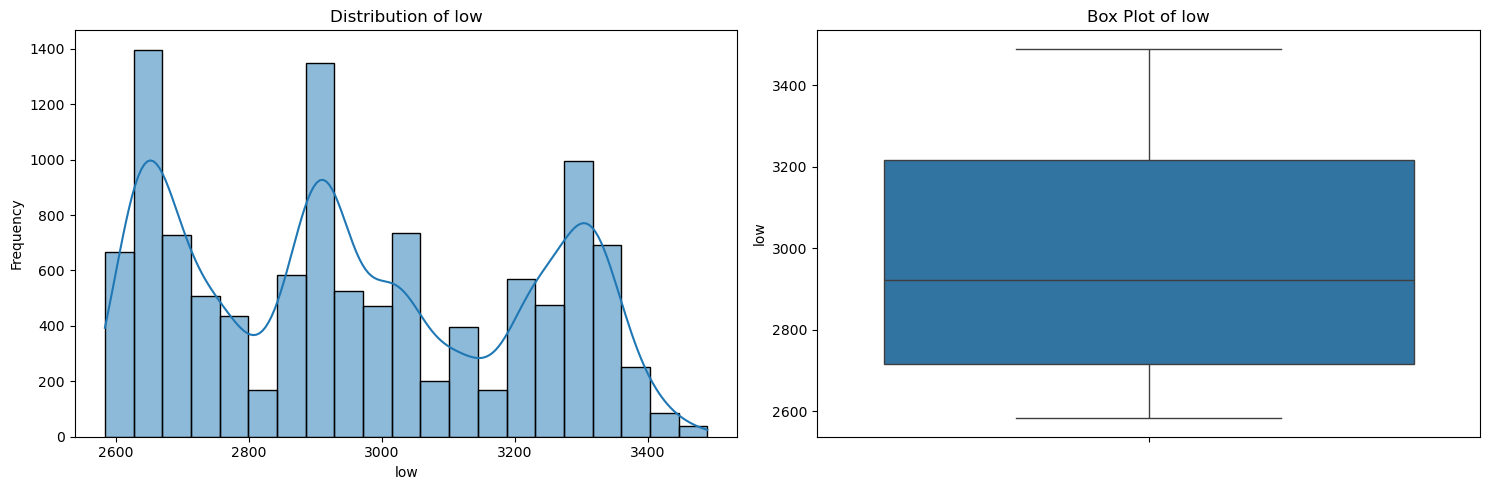

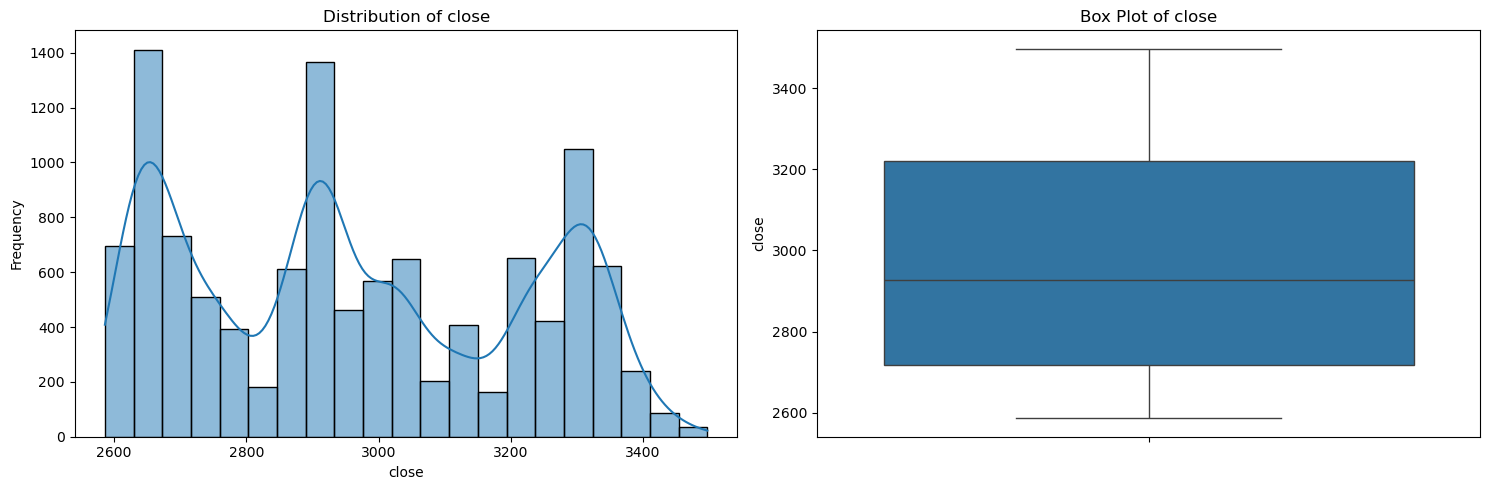

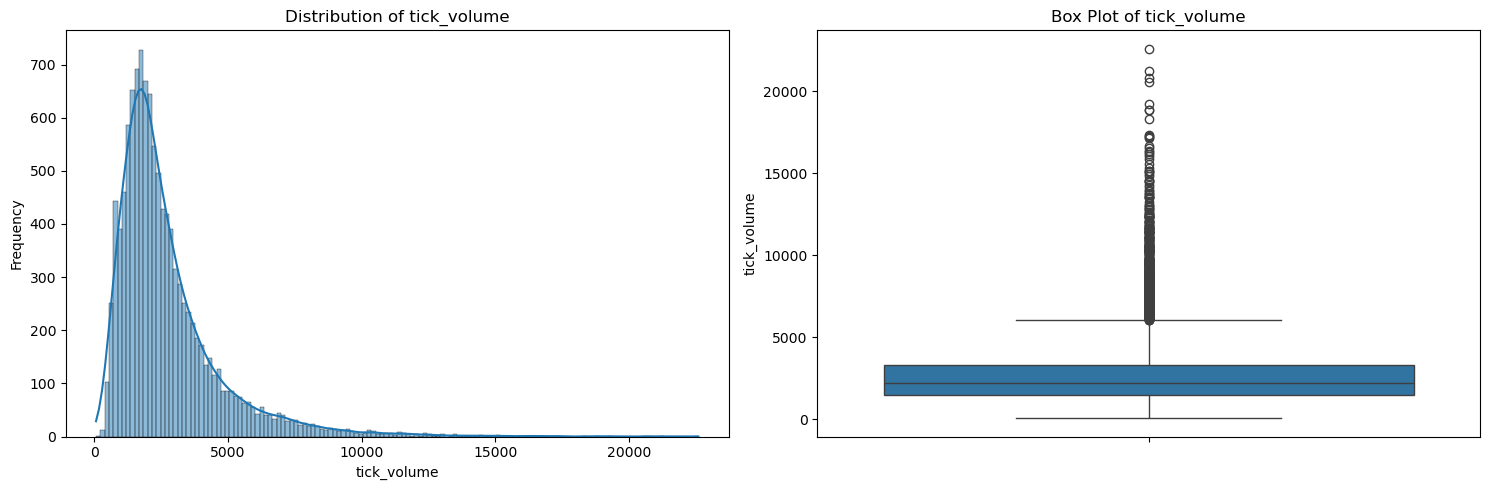

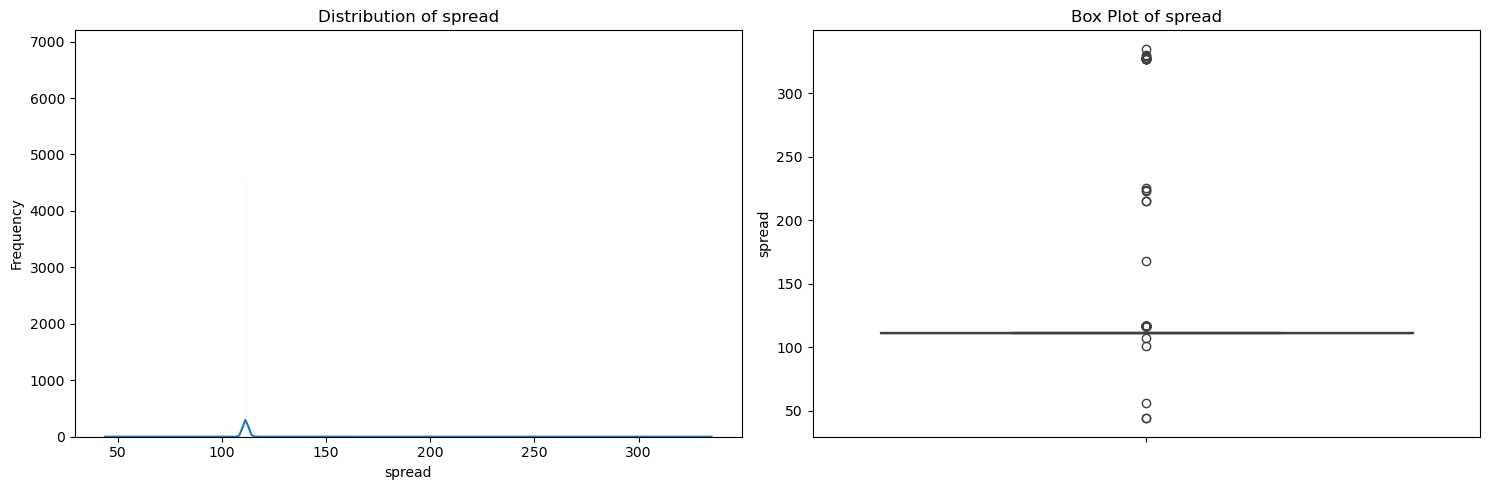

In [23]:
# 3.2. Histogram dan Box Plot untuk Setiap Fitur Numerik
print("\n--- 3.2. Histogram dan Box Plot untuk Setiap Fitur Numerik ---")

# Pilih kolom-kolom numerik yang relevan (tidak termasuk 'time' karena sudah jadi indeks)
numerical_cols = ['open', 'high', 'low', 'close', 'tick_volume', 'spread']

for col in numerical_cols:
    plt.figure(figsize=(15, 5))

    # Histogram
    plt.subplot(1, 2, 1) # 1 baris, 2 kolom, plot ke-1
    sns.histplot(df_eda[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Box Plot
    plt.subplot(1, 2, 2) # 1 baris, 2 kolom, plot ke-2
    sns.boxplot(y=df_eda[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)

    plt.tight_layout() # Untuk menyesuaikan layout agar tidak tumpang tindih
    plt.show()


--- 3.3. Correlation Matrix Heatmap ---


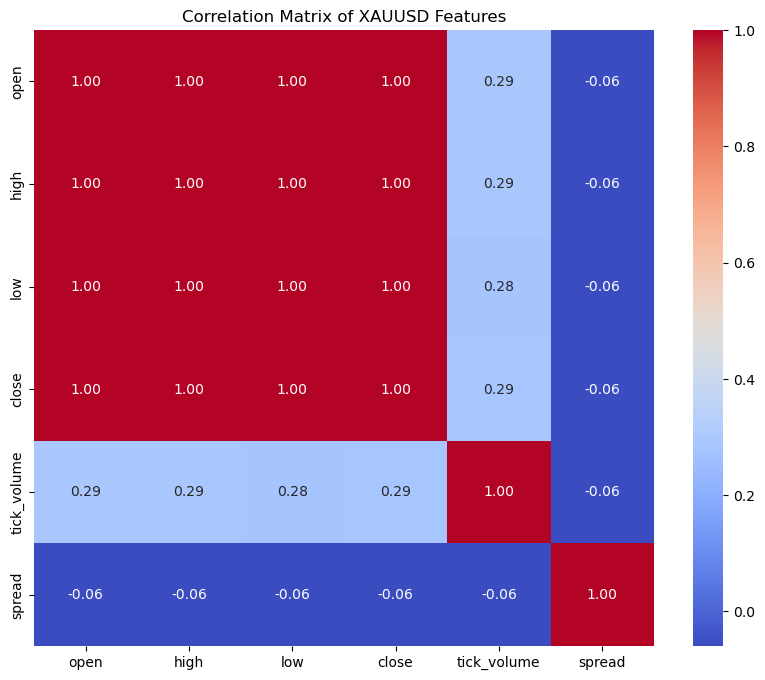


EDA Visualisasi Mendalam selesai! Sekarang kita punya gambaran yang lebih baik tentang data kita. 😊


In [24]:
# 3.3. Correlation Matrix Heatmap
print("\n--- 3.3. Correlation Matrix Heatmap ---")

# Hitung matriks korelasi
correlation_matrix = df_eda[numerical_cols].corr()

# Buat heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of XAUUSD Features')
plt.show()

print("\nEDA Visualisasi Mendalam selesai! Sekarang kita punya gambaran yang lebih baik tentang data kita. 😊")

# Preprocessing

In [25]:
# Asumsikan df sudah tersedia dan 'time' sudah menjadi DatetimeIndex dari cell sebelumnya
# Asumsikan juga library yang dibutuhkan seperti pandas, numpy, sklearn.preprocessing.MinMaxScaler sudah diimport

print("\n--- 4. Preprocessing Data ---")

# 4.1. Feature Selection and Transformation (Log Transform)
print("\n--- 4.1. Feature Selection and Transformation ---")

# Drop 'real_volume' jika ada dan semua nilainya nol (sesuai hasil EDA)
if 'real_volume' in df.columns and df['real_volume'].sum() == 0:
    df_processed = df.drop(columns=['real_volume'])
    print("Kolom 'real_volume' di-drop karena semua nilainya nol.")
else:
    df_processed = df.copy()
    print("Kolom 'real_volume' tidak di-drop atau tidak ditemukan.")


--- 4. Preprocessing Data ---

--- 4.1. Feature Selection and Transformation ---
Kolom 'real_volume' di-drop karena semua nilainya nol.


In [26]:
# Define fitur-fitur yang akan digunakan
# Urutan fitur ini PENTING dan harus konsisten, terutama saat membuat X dan Y
features_for_modeling = ['open', 'high', 'low', 'close', 'tick_volume', 'spread']
print(f"Fitur yang dipilih untuk pemodelan: {features_for_modeling}")

Fitur yang dipilih untuk pemodelan: ['open', 'high', 'low', 'close', 'tick_volume', 'spread']


In [27]:
# Membuat DataFrame baru hanya dengan fitur yang akan digunakan
df_features = df_processed[features_for_modeling].copy()

In [28]:
# Terapkan transformasi log1p pada 'tick_volume' dan 'spread'
# Ini akan membantu menormalisasi distribusi yang sangat miring
df_features['tick_volume'] = np.log1p(df_features['tick_volume'])
df_features['spread'] = np.log1p(df_features['spread'])
print("Transformasi log1p telah diterapkan pada 'tick_volume' dan 'spread'.")

Transformasi log1p telah diterapkan pada 'tick_volume' dan 'spread'.


In [29]:
# Ubah DataFrame menjadi array NumPy untuk scaling
data_for_scaling = df_features.values
print(f"Bentuk data untuk scaling: {data_for_scaling.shape}")

Bentuk data untuk scaling: (11453, 6)


In [30]:
# 4.2. Feature Scaling
print("\n--- 4.2. Feature Scaling ---")

# Scaler utama untuk semua fitur input
scaler_features = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler_features.fit_transform(data_for_scaling)
print(f"Bentuk data setelah scaling fitur: {scaled_data.shape}")


--- 4.2. Feature Scaling ---
Bentuk data setelah scaling fitur: (11453, 6)


In [31]:
# Scaler terpisah khusus untuk kolom 'close' (target)
# Ini SANGAT PENTING agar kita bisa melakukan inverse_transform prediksi 'close' dengan benar
# Kita fit scaler_close hanya pada kolom 'close' dari df_features yang asli
scaler_close = MinMaxScaler(feature_range=(0,1))
scaler_close.fit(df_features[['close']].values)
print("Scaler terpisah untuk 'close' price telah diinisialisasi dan di-fit.")


print("Data fitur telah di-scale ke rentang [0, 1].")

Scaler terpisah untuk 'close' price telah diinisialisasi dan di-fit.
Data fitur telah di-scale ke rentang [0, 1].


In [32]:
# 4.3. Split Data (Training/Testing)
print("\n--- 4.3. Split Data (Training/Testing) ---")

# Ukuran training 80% dari total data
training_size = int(len(scaled_data) * 0.80)
train_data_initial = scaled_data[0:training_size, :]
test_data_initial = scaled_data[training_size:, :]

print(f"Ukuran data training awal: {train_data_initial.shape}")
print(f"Ukuran data testing awal: {test_data_initial.shape}")


--- 4.3. Split Data (Training/Testing) ---
Ukuran data training awal: (9162, 6)
Ukuran data testing awal: (2291, 6)


In [33]:
# 4.4. Pembuatan Fitur dan Label (split_sequence)
# PASTIKAN DEFINISI FUNGSI split_sequence INI ADA DI NOTEBOOK-mu
# Biasanya di cell 839eda75 atau cell tempat kamu definisikan fungsi ini.
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    # Asumsi kolom 'close' adalah target, dan posisinya di `features_for_modeling` adalah index 3
    # features_for_modeling = ['open', 'high', 'low', 'close', 'tick_volume', 'spread']
    # Maka kolom close adalah index 3
    target_column_index = features_for_modeling.index('close')

    for i in range(len(sequence)):
       end_ix = i + n_steps
       if end_ix > len(sequence)-1:
          break
       # seq_x akan mengambil SEMUA fitur dari n_steps sebelumnya
       # seq_y akan mengambil hanya kolom 'close' dari time_step berikutnya
       seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix, target_column_index]
       X.append(seq_x)
       y.append(seq_y)
    return np.array(X), np.array(y)

In [34]:
print("\n--- 4.4. Pembuatan Fitur dan Label (split_sequence) ---")

time_step = 120 # Jumlah candle masa lalu yang akan digunakan sebagai input

# Panggil fungsi split_sequence untuk data training dan testing
x_train, y_train = split_sequence(train_data_initial, time_step)
x_test, y_test = split_sequence(test_data_initial, time_step)

# Reshape input untuk LSTM: [samples, time steps, features]
# Jumlah features sekarang adalah len(features_for_modeling) yaitu 6
num_features = len(features_for_modeling)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], num_features)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], num_features)

print(f"Bentuk x_train setelah split dan reshape: {x_train.shape}")
print(f"Bentuk y_train setelah split dan reshape: {y_train.shape}")
print(f"Bentuk x_test setelah split dan reshape: {x_test.shape}")
print(f"Bentuk y_test setelah split dan reshape: {y_test.shape}")


--- 4.4. Pembuatan Fitur dan Label (split_sequence) ---
Bentuk x_train setelah split dan reshape: (9042, 120, 6)
Bentuk y_train setelah split dan reshape: (9042,)
Bentuk x_test setelah split dan reshape: (2171, 120, 6)
Bentuk y_test setelah split dan reshape: (2171,)


In [35]:
print("\nPreprocessing selesai! Data telah disiapkan untuk model LSTM. 💪")



Preprocessing selesai! Data telah disiapkan untuk model LSTM. 💪


# Model Architechture

## Model 1

In [36]:
# Clear session dan set seed untuk reproduktifitas
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Pastikan K (backend) dan gc terimport dan berfungsi
# from tensorflow.keras import backend as K # Pastikan ini diimport di Libraries
# import gc # Pastikan ini diimport di Libraries
K.clear_session()
gc.collect()
print("Session dan GPU memory telah dibersihkan untuk Model 1.")

Session dan GPU memory telah dibersihkan untuk Model 1.


In [37]:
# Definisikan arsitektur Model 1
# Input shape: (time_step, num_features)
# time_step (x_train.shape[1]) dan num_features (jumlah fitur yang kita pakai)
model1 = Sequential()
model1.add(Conv1D(filters=256, kernel_size=2, activation='relu', padding='same', input_shape=(x_train.shape[1], num_features)))
model1.add(MaxPooling1D(pool_size=2))
model1.add(LSTM(150, return_sequences=True)) # Menggunakan 150 unit seperti diskusi
model1.add(Dropout(0.3))
model1.add(LSTM(150, return_sequences=False)) # Menggunakan 150 unit
model1.add(Dropout(0.3))
model1.add(Dense(units=1, activation='sigmoid')) # Output 1 unit dengan sigmoid karena target sudah diskala 0-1
model1.compile(optimizer='adam', loss='mse', metrics=[rmse()])

In [38]:
# Tampilkan ringkasan model
print("\nRingkasan Model 1:")
model1.summary()

# Plot Model (opsional, perlu Graphviz terinstal)
# from keras.utils.vis_utils import plot_model # Pastikan ini diimport di Libraries
# plot_model(model1, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)
# print("\nDiagram Model 1 disimpan sebagai model1_plot.png")


Ringkasan Model 1:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 120, 256)          3328      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 60, 256)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 60, 150)           244200    
                                                                 
 dropout (Dropout)           (None, 60, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 150)               180600    
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                    

In [39]:
# --- Model 2 ---
print("\n## Model 2 (Vanilla LSTM - Multivariate)")

# Clear session dan set seed untuk reproduktifitas
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
K.clear_session()
gc.collect()
print("Session dan GPU memory telah dibersihkan untuk Model 2.")


## Model 2 (Vanilla LSTM - Multivariate)
Session dan GPU memory telah dibersihkan untuk Model 2.


In [40]:
# Definisikan arsitektur Model 2 (sesuai Vord.ipynb, tapi input_shape disesuaikan)
# Input shape: (time_step, num_features)
model2 = Sequential()
# Input shape: (x_train.shape[1], num_features)
model2.add(LSTM(32, return_sequences=True, input_shape=(x_train.shape[1], num_features))) # Disini juga pakai num_features
model2.add(Dropout(0.4))
model2.add(LSTM(32))
model2.add(Dropout(0.4))
model2.add(Dense(1, activation='sigmoid')) # Tambahkan aktivasi sigmoid untuk konsistensi dengan target skala 0-1

# Compile Model 2
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse()]) # Tambahkan rmse sebagai metrik

In [41]:
# Tampilkan ringkasan model
print("\nRingkasan Model 2:")
model2.summary()

# Plot Model (opsional)
# plot_model(model2, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)
# print("\nDiagram Model 2 disimpan sebagai model2_plot.png")

print("\nKedua arsitektur model telah didefinisikan. 🎉")


Ringkasan Model 2:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120, 32)           4992      
                                                                 
 dropout (Dropout)           (None, 120, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 13,345
Trainable params: 13,345
Non-trainable params: 0
_________________________________________________________________

Kedua arsitektur model telah di

# Training

In [42]:
# Asumsikan variabel seperti x_train, y_train, x_test, y_test, num_features,
# scaler_features, dan scaler_close sudah tersedia dari cell Preprocessing sebelumnya.
# Pastikan library yang dibutuhkan sudah diimport di bagian Libraries (numpy, pandas, matplotlib, seaborn,
# tensorflow, keras.models.Sequential, keras.layers.LSTM, Dense, Dropout, Conv1D, MaxPooling1D,
# RootMeanSquaredError as rmse, EarlyStopping, ModelCheckpoint, K.clear_session, gc.collect, time).

print("\n--- 6. Model Training & Evaluation ---")

# --- Model 1 ---
print("\n## Model 1 (CNN-LSTM - Multivariate) - Training & Evaluation")

# Clear session dan set seed untuk reproduktifitas sebelum training Model 1
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
K.clear_session() # Membersihkan GPU memory
gc.collect() # Melakukan garbage collection
print("Session dan GPU memory telah dibersihkan untuk Model 1.")


--- 6. Model Training & Evaluation ---

## Model 1 (CNN-LSTM - Multivariate) - Training & Evaluation
Session dan GPU memory telah dibersihkan untuk Model 1.


In [43]:
# Definisikan ulang Model 1 di sini (sesuai definisi Model 1 di cell sebelumnya)
# Ini untuk memastikan model dibuat dari awal setelah clear_session
model1 = Sequential()
model1.add(Conv1D(filters=256, kernel_size=2, activation='relu', padding='same', input_shape=(x_train.shape[1], num_features)))
model1.add(MaxPooling1D(pool_size=2))
model1.add(LSTM(150, return_sequences=True))
model1.add(Dropout(0.3))
model1.add(LSTM(150, return_sequences=False))
model1.add(Dropout(0.3))
model1.add(Dense(units=1, activation='sigmoid'))
model1.compile(optimizer='adam', loss='mse', metrics=[rmse()])
print("\nArsitektur Model 1 telah dibuat ulang.")
model1.summary() # Tampilkan ringkasan model lagi


Arsitektur Model 1 telah dibuat ulang.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 120, 256)          3328      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 60, 256)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 60, 150)           244200    
                                                                 
 dropout (Dropout)           (None, 60, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 150)               180600    
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                

In [44]:
# Callback EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Ukur waktu training Model 1
time_calc_start_m1 = time.time()

# Fit Model 1
print("\nMemulai training Model 1...")
history_m1 = model1.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=300, # Max 300 epochs, EarlyStopping akan menghentikan lebih awal jika konvergen
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

fit_time_seconds_m1 = time.time() - time_calc_start_m1
print(f"\nFit time Model 1 = {fit_time_seconds_m1:.2f} seconds.")


Memulai training Model 1...
Epoch 1/300
283/283 [==============================] - 30s 62ms/step - loss: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 3.6824e-04 - val_root_mean_squared_error: 0.0192
Epoch 2/300
283/283 [==============================] - 13s 46ms/step - loss: 3.0731e-04 - root_mean_squared_error: 0.0175 - val_loss: 3.5858e-04 - val_root_mean_squared_error: 0.0189
Epoch 3/300
283/283 [==============================] - 13s 45ms/step - loss: 2.8035e-04 - root_mean_squared_error: 0.0167 - val_loss: 2.4938e-04 - val_root_mean_squared_error: 0.0158
Epoch 4/300
283/283 [==============================] - 16s 57ms/step - loss: 2.8915e-04 - root_mean_squared_error: 0.0170 - val_loss: 3.5670e-04 - val_root_mean_squared_error: 0.0189
Epoch 5/300
283/283 [==============================] - 16s 57ms/step - loss: 2.3438e-04 - root_mean_squared_error: 0.0153 - val_loss: 4.3078e-04 - val_root_mean_squared_error: 0.0208
Epoch 6/300
283/283 [==============================] - 17s 5


Visualisasi Loss Curve Model 1:


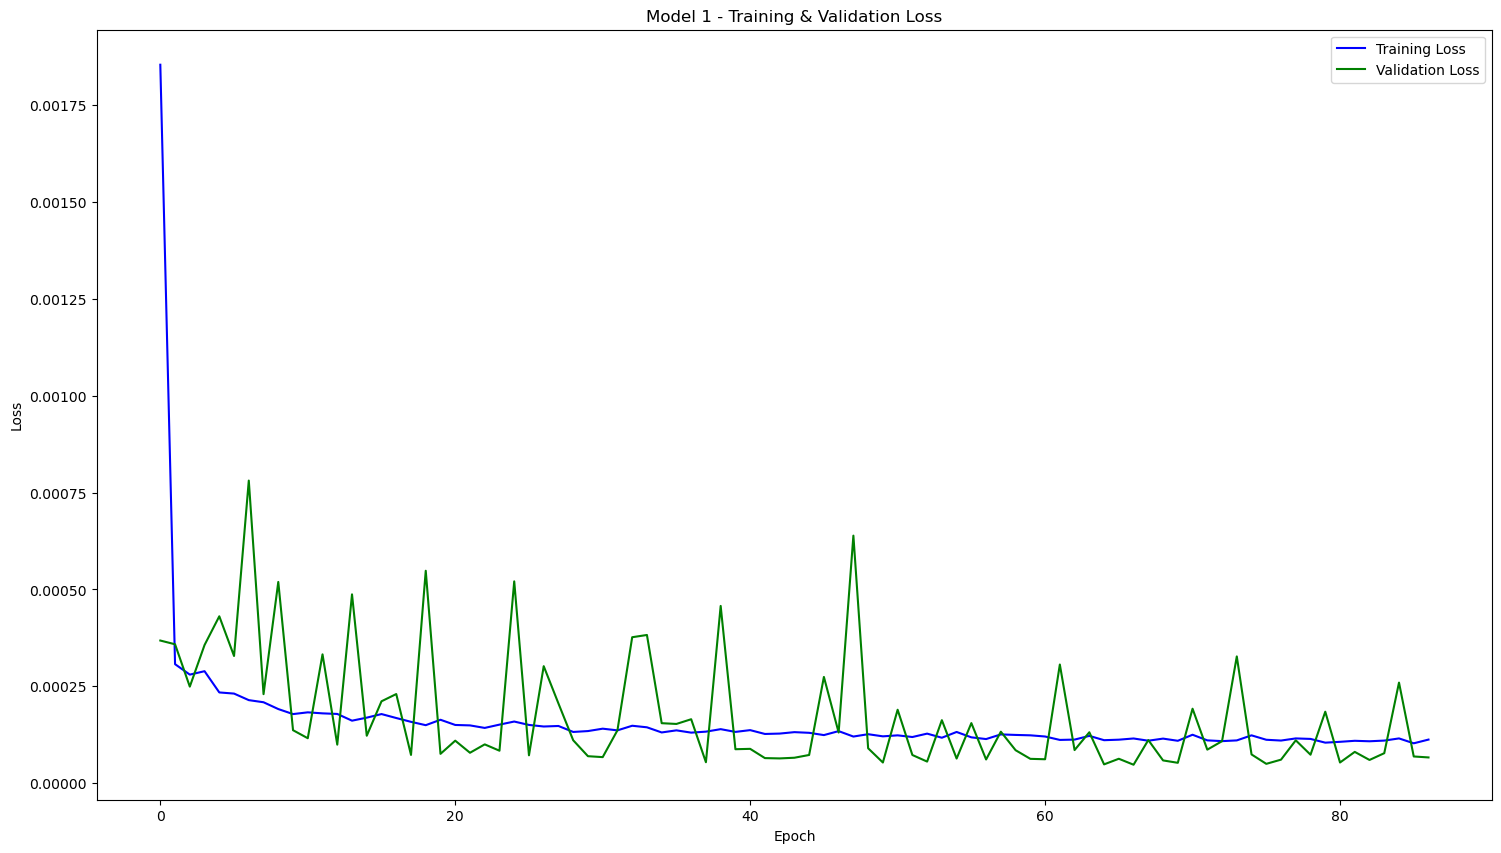

In [45]:
# Visualisasi Loss Curve Model 1
print("\nVisualisasi Loss Curve Model 1:")
plt.figure(figsize = (18,10))
plt.plot(history_m1.history['loss'],label='Training Loss',color='b')
plt.plot(history_m1.history['val_loss'],label='Validation Loss',color='g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model 1 - Training & Validation Loss")
plt.legend()
plt.show()


In [46]:
# Evaluasi Model 1
print("\nEvaluasi Model 1 pada data training:")
model1.evaluate(x_train, y_train, batch_size=32)


Evaluasi Model 1 pada data training:
283/283 [==============================] - 3s 12ms/step - loss: 2.9848e-05 - root_mean_squared_error: 0.0055


[2.9847922633052804e-05, 0.005463324952870607]

In [47]:

print("\nEvaluasi Model 1 pada data testing:")
model1.evaluate(x_test, y_test, batch_size=32)


Evaluasi Model 1 pada data testing:
68/68 [==============================] - 1s 13ms/step - loss: 4.7951e-05 - root_mean_squared_error: 0.0069


[4.79514965263661e-05, 0.006924701854586601]

In [48]:
# Prediksi dan Inverse Transform untuk Model 1
print("\nMelakukan prediksi dan Inverse Transform untuk Model 1...")
train_predict_m1_scaled = model1.predict(x_train)
test_predict_m1_scaled = model1.predict(x_test)


Melakukan prediksi dan Inverse Transform untuk Model 1...
68/68 [==============================] - 1s 9ms/step


In [49]:
# Inverse transform y_train dan y_test (karena hanya satu kolom 'close' yang menjadi target)
# Kita perlu membuat dummy array dengan bentuk yang sama saat scaler_close di-fit (n_samples, n_features)
# Di sini, scaler_close di-fit pada (n_samples, 1) karena hanya kolom 'close'
# Jadi, kita perlu reshape y_train dan y_test agar sesuai untuk inverse_transform
y_train_actual_m1 = scaler_close.inverse_transform(y_train.reshape(-1, 1))
y_test_actual_m1 = scaler_close.inverse_transform(y_test.reshape(-1, 1))

In [50]:
# Untuk prediksi, kita juga perlu membuat dummy array untuk inverse_transform
# Karena prediksi hanya 1 kolom, kita reshape menjadi (n_samples, 1)
train_predict_m1_actual = scaler_close.inverse_transform(train_predict_m1_scaled)
test_predict_m1_actual = scaler_close.inverse_transform(test_predict_m1_scaled)

In [51]:
# Hitung metrik Model 1
from sklearn import metrics # Pastikan ini diimport
from sklearn.metrics import r2_score # Pastikan ini diimport

rmse_train_m1 = np.sqrt(metrics.mean_squared_error(y_train_actual_m1, train_predict_m1_actual))
mse_train_m1 = metrics.mean_squared_error(y_train_actual_m1, train_predict_m1_actual)
r2_train_m1 = r2_score(y_train_actual_m1, train_predict_m1_actual)

In [52]:


rmse_test_m1 = np.sqrt(metrics.mean_squared_error(y_test_actual_m1, test_predict_m1_actual))
mse_test_m1 = metrics.mean_squared_error(y_test_actual_m1, test_predict_m1_actual)
r2_test_m1 = r2_score(y_test_actual_m1, test_predict_m1_actual)

In [53]:


print("\n--- Metrik Kinerja Model 1 ---")
print(f"Training RMSE: {rmse_train_m1:.4f}")
print(f"Training MSE : {mse_train_m1:.4f}")
print(f"Training R2  : {r2_train_m1:.4f}")
print(f"Testing RMSE : {rmse_test_m1:.4f}")
print(f"Testing MSE  : {mse_test_m1:.4f}")
print(f"Testing R2   : {r2_test_m1:.4f}")


--- Metrik Kinerja Model 1 ---
Training RMSE: 4.9801
Training MSE : 24.8014
Training R2  : 0.9994
Testing RMSE : 6.3122
Testing MSE  : 39.8442
Testing R2   : 0.9876



Visualisasi Prediksi vs Aktual Model 1 (Training Data):


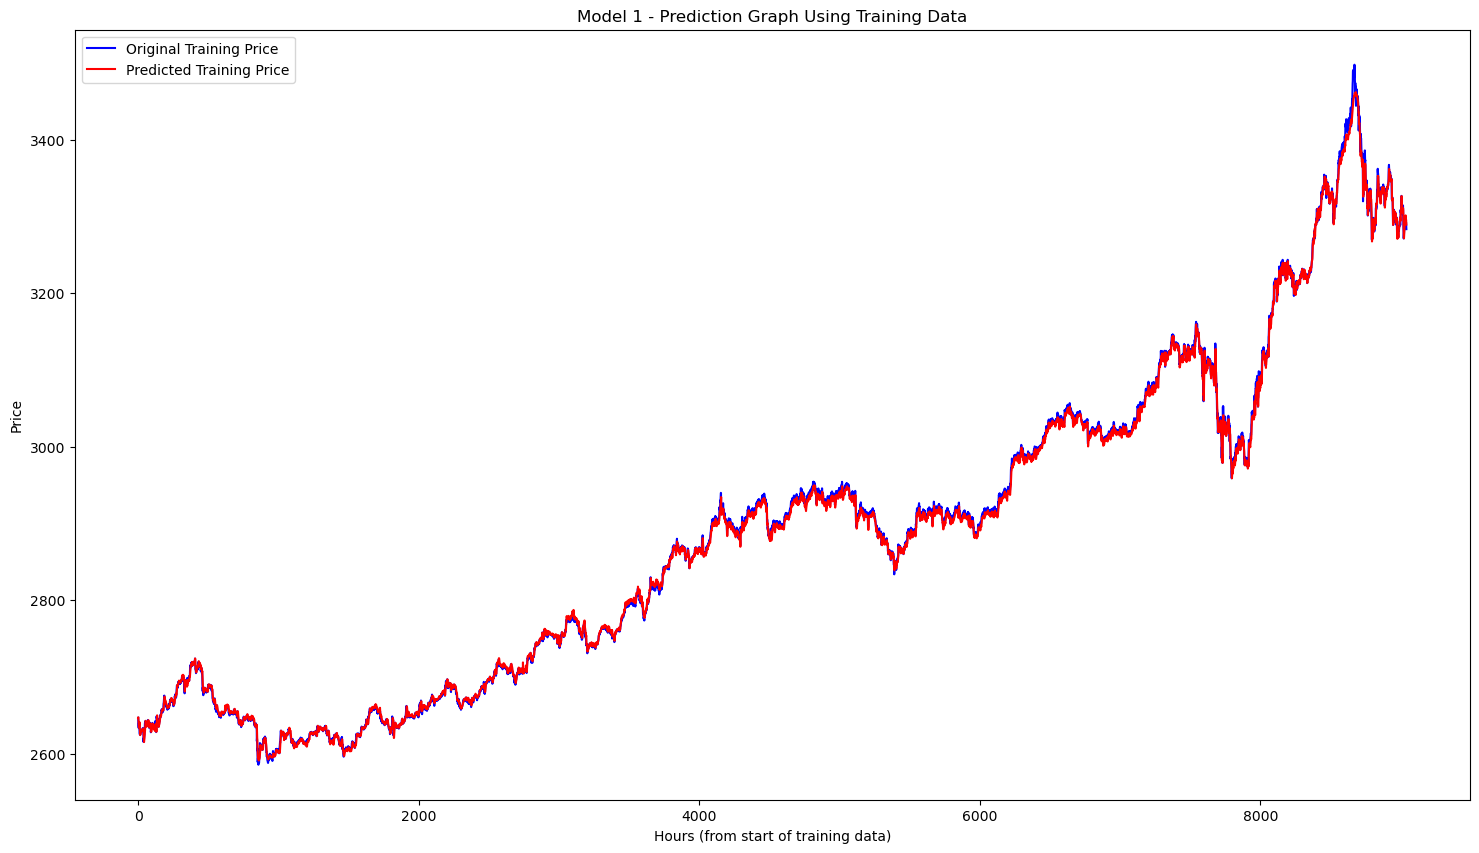

In [54]:
# Visualisasi Prediksi vs Aktual Model 1 (Training Data)
print("\nVisualisasi Prediksi vs Aktual Model 1 (Training Data):")
plt.figure(figsize=(18,10))
plt.plot(y_train_actual_m1, color = 'b', label = 'Original Training Price')
plt.plot(train_predict_m1_actual, color='red', label = 'Predicted Training Price')
plt.title("Model 1 - Prediction Graph Using Training Data")
plt.xlabel("Hours (from start of training data)")
plt.ylabel("Price")
plt.legend()
plt.show()


Visualisasi Prediksi vs Aktual Model 1 (Testing Data):


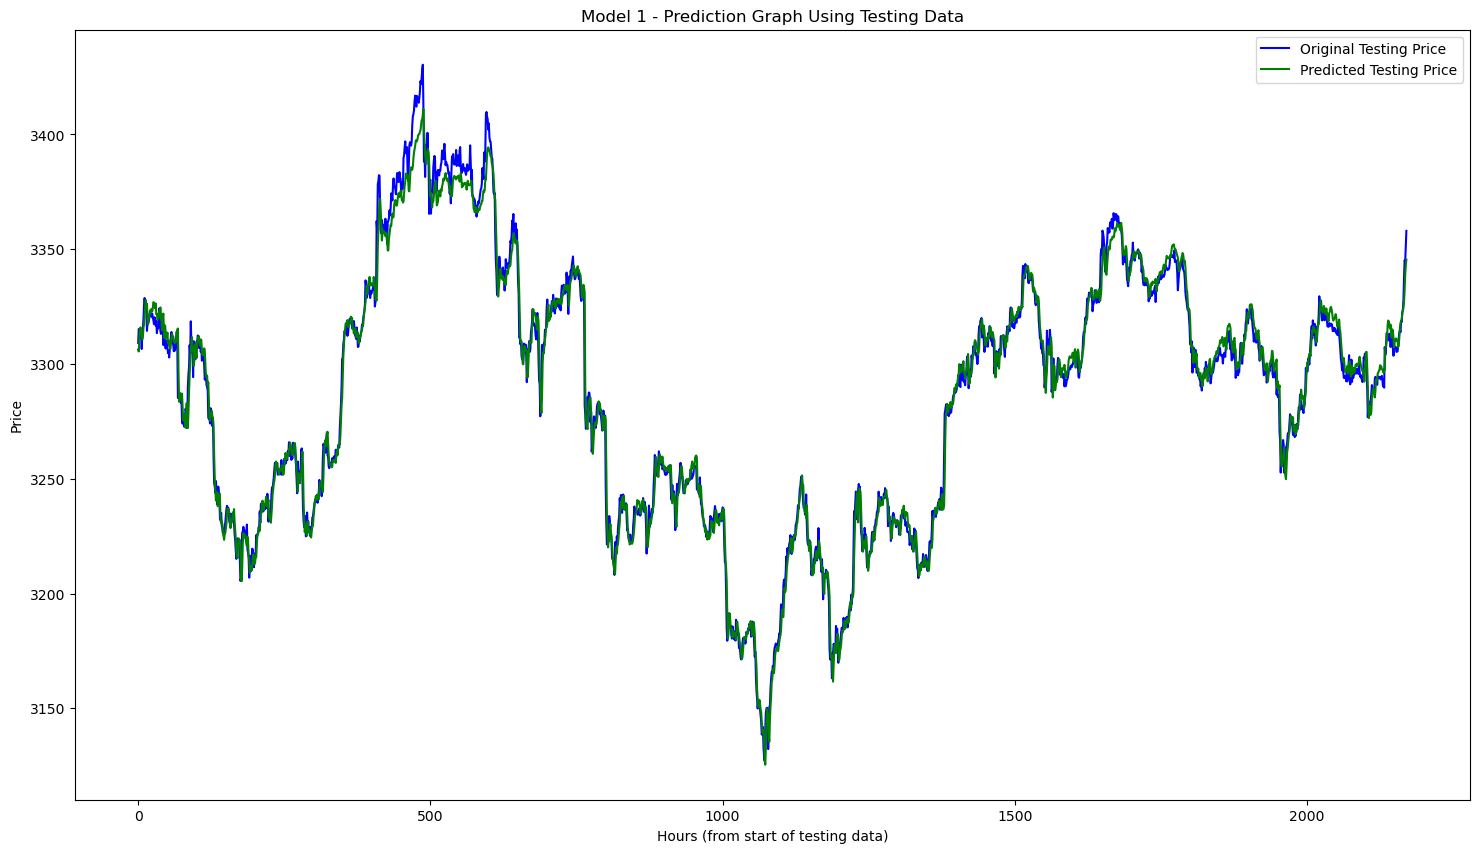


--------------------------------------------------------------


In [55]:
# Visualisasi Prediksi vs Aktual Model 1 (Testing Data)
print("\nVisualisasi Prediksi vs Aktual Model 1 (Testing Data):")
plt.figure(figsize=(18,10))
plt.plot(y_test_actual_m1, color = 'b', label = 'Original Testing Price')
plt.plot(test_predict_m1_actual, color='g', label = 'Predicted Testing Price')
plt.title("Model 1 - Prediction Graph Using Testing Data")
plt.xlabel("Hours (from start of testing data)")
plt.ylabel("Price")
plt.legend()
plt.show()

print("\n--------------------------------------------------------------")

Confusion Matrix:
 [[520 550]
 [491 609]]
Akurasi prediksi arah: 0.5203
              precision    recall  f1-score   support

           0     0.5143    0.4860    0.4998      1070
           1     0.5255    0.5536    0.5392      1100

    accuracy                         0.5203      2170
   macro avg     0.5199    0.5198    0.5195      2170
weighted avg     0.5200    0.5203    0.5197      2170



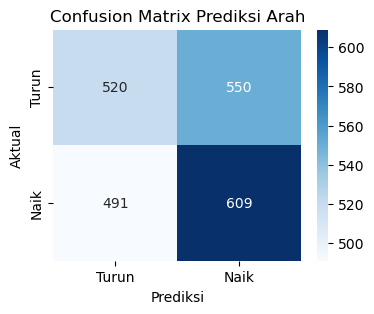

In [56]:
# y_test_actual_m1 = label aktual (sudah inverse)
# test_predict_m1  = hasil prediksi model, juga harus sudah inverse!

# (Pastikan test_predict_m1 sudah di-inverse dengan scaler_close)
test_predict_m1 = scaler_close.inverse_transform(test_predict_m1_scaled)

y_true = y_test_actual_m1.flatten()
y_pred = test_predict_m1.flatten()

# Prediksi arah (naik/turun)
true_dir = (y_true[1:] > y_true[:-1]).astype(int)
pred_dir = (y_pred[1:] > y_true[:-1]).astype(int)

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_dir, pred_dir)
acc = accuracy_score(true_dir, pred_dir)

print("Confusion Matrix:\n", cm)
print(f"Akurasi prediksi arah: {acc:.4f}")
print(classification_report(true_dir, pred_dir, digits=4))

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Turun','Naik'], yticklabels=['Turun','Naik'])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix Prediksi Arah")
plt.show()


In [57]:
# save model to ONNX
output_path = "model1.test.onnx"
onnx_model = tf2onnx.convert.from_keras(model1, output_path=output_path)
print(f"saved model to {output_path}")

# finish
mt5.shutdown()

saved model to model1.test.onnx


True

In [58]:
# --- Model 2 ---
print("\n## Model 2 (Vanilla LSTM - Multivariate) - Training & Evaluation")

# Clear session dan set seed untuk reproduktifitas sebelum training Model 2
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
K.clear_session()
gc.collect()
print("Session dan GPU memory telah dibersihkan untuk Model 2.")


## Model 2 (Vanilla LSTM - Multivariate) - Training & Evaluation
Session dan GPU memory telah dibersihkan untuk Model 2.


In [59]:
# Definisikan ulang Model 2 di sini (sesuai definisi Model 2 di cell sebelumnya)
model2 = Sequential()
model2.add(LSTM(32, return_sequences=True, input_shape=(x_train.shape[1], num_features)))
model2.add(Dropout(0.4))
model2.add(LSTM(32))
model2.add(Dropout(0.4))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse()])
print("\nArsitektur Model 2 telah dibuat ulang.")
model2.summary() # Tampilkan ringkasan model lagi


Arsitektur Model 2 telah dibuat ulang.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120, 32)           4992      
                                                                 
 dropout (Dropout)           (None, 120, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 13,345
Trainable params: 13,345
Non-trainable params: 0
_________________________________________________________________


In [60]:
# Callback EarlyStopping untuk Model 2
early_stop_m2 = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Ukur waktu training Model 2
time_calc_start_m2 = time.time()

# Fit Model 2
print("\nMemulai training Model 2...")
history_m2 = model2.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=300,
    batch_size=64, # Menggunakan batch_size 64 sesuai Model 2 di Vord.ipynb
    callbacks=[early_stop_m2],
    verbose=1
)

fit_time_seconds_m2 = time.time() - time_calc_start_m2
print(f"\nFit time Model 2 = {fit_time_seconds_m2:.2f} seconds.")


Memulai training Model 2...
Epoch 1/300
142/142 [==============================] - 8s 39ms/step - loss: 0.0093 - root_mean_squared_error: 0.0966 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573
Epoch 2/300
142/142 [==============================] - 5s 34ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 3/300
142/142 [==============================] - 5s 34ms/step - loss: 0.0012 - root_mean_squared_error: 0.0349 - val_loss: 3.8341e-04 - val_root_mean_squared_error: 0.0196
Epoch 4/300
142/142 [==============================] - 5s 34ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 5.1154e-04 - val_root_mean_squared_error: 0.0226
Epoch 5/300
142/142 [==============================] - 5s 34ms/step - loss: 9.8353e-04 - root_mean_squared_error: 0.0314 - val_loss: 3.1924e-04 - val_root_mean_squared_error: 0.0179
Epoch 6/300
142/142 [==============================] - 5s 33ms/step - loss: 9.1164e-0


Visualisasi Loss Curve Model 2:


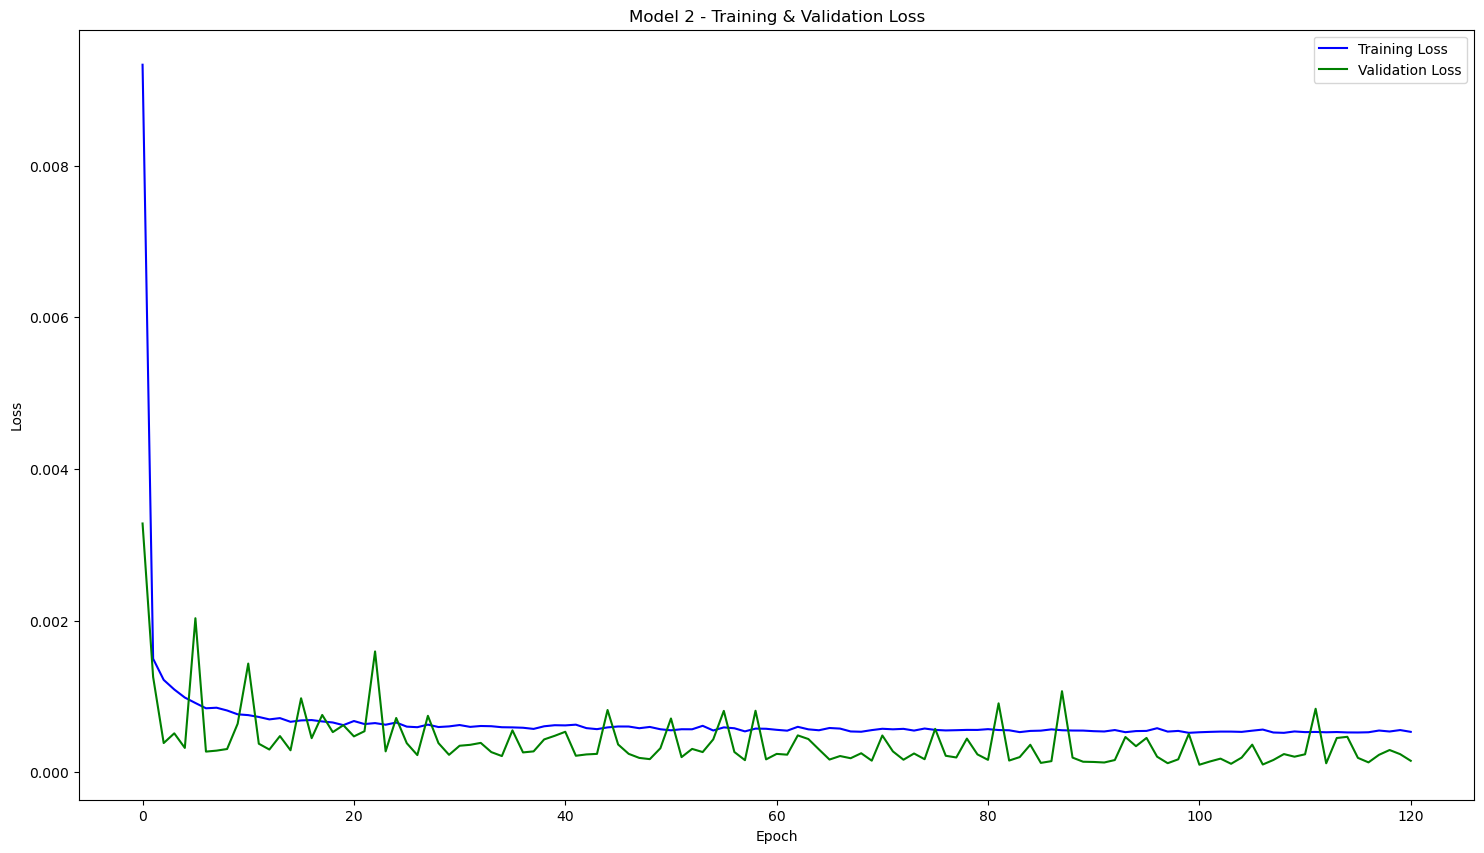

In [61]:
# Visualisasi Loss Curve Model 2
print("\nVisualisasi Loss Curve Model 2:")
plt.figure(figsize = (18,10))
plt.plot(history_m2.history['loss'],label='Training Loss',color='b')
plt.plot(history_m2.history['val_loss'],label='Validation Loss',color='g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model 2 - Training & Validation Loss")
plt.legend()
plt.show()

In [62]:
# Evaluasi Model 2
print("\nEvaluasi Model 2 pada data training:")
model2.evaluate(x_train, y_train, batch_size=32)
print("\nEvaluasi Model 2 pada data testing:")
model2.evaluate(x_test, y_test, batch_size=32)


Evaluasi Model 2 pada data training:
283/283 [==============================] - 4s 15ms/step - loss: 6.8949e-05 - root_mean_squared_error: 0.0083

Evaluasi Model 2 pada data testing:
68/68 [==============================] - 1s 15ms/step - loss: 9.7539e-05 - root_mean_squared_error: 0.0099


[9.753869380801916e-05, 0.00987616740167141]

In [63]:
# Prediksi dan Inverse Transform untuk Model 2
print("\nMelakukan prediksi dan Inverse Transform untuk Model 2...")
train_predict_m2_scaled = model2.predict(x_train)
test_predict_m2_scaled = model2.predict(x_test)


Melakukan prediksi dan Inverse Transform untuk Model 2...
68/68 [==============================] - 1s 12ms/step


In [64]:
# Inverse transform y_train dan y_test menggunakan scaler_close (sudah dilakukan di Model 1, tapi untuk kejelasan)
# y_train_actual_m2 = scaler_close.inverse_transform(y_train.reshape(-1, 1)) # Seharusnya sudah sama dengan y_train_actual_m1
# y_test_actual_m2 = scaler_close.inverse_transform(y_test.reshape(-1, 1))   # Seharusnya sudah sama dengan y_test_actual_m1

train_predict_m2_actual = scaler_close.inverse_transform(train_predict_m2_scaled)
test_predict_m2_actual = scaler_close.inverse_transform(test_predict_m2_scaled)

In [65]:

# Hitung metrik Model 2
rmse_train_m2 = np.sqrt(metrics.mean_squared_error(y_train_actual_m1, train_predict_m2_actual)) # Menggunakan y_train_actual_m1/y_test_actual_m1
mse_train_m2 = metrics.mean_squared_error(y_train_actual_m1, train_predict_m2_actual)
r2_train_m2 = r2_score(y_train_actual_m1, train_predict_m2_actual)

In [66]:

rmse_test_m2 = np.sqrt(metrics.mean_squared_error(y_test_actual_m1, test_predict_m2_actual))
mse_test_m2 = metrics.mean_squared_error(y_test_actual_m1, test_predict_m2_actual)
r2_test_m2 = r2_score(y_test_actual_m1, test_predict_m2_actual)

In [67]:
print("\n--- Metrik Kinerja Model 2 ---")
print(f"Training RMSE: {rmse_train_m2:.4f}")
print(f"Training MSE : {mse_train_m2:.4f}")
print(f"Training R2  : {r2_train_m2:.4f}")
print(f"Testing RMSE : {rmse_test_m2:.4f}")
print(f"Testing MSE  : {mse_test_m2:.4f}")
print(f"Testing R2   : {r2_test_m2:.4f}")


--- Metrik Kinerja Model 2 ---
Training RMSE: 7.5691
Training MSE : 57.2917
Training R2  : 0.9987
Testing RMSE : 9.0026
Testing MSE  : 81.0475
Testing R2   : 0.9748



Visualisasi Prediksi vs Aktual Model 2 (Training Data):


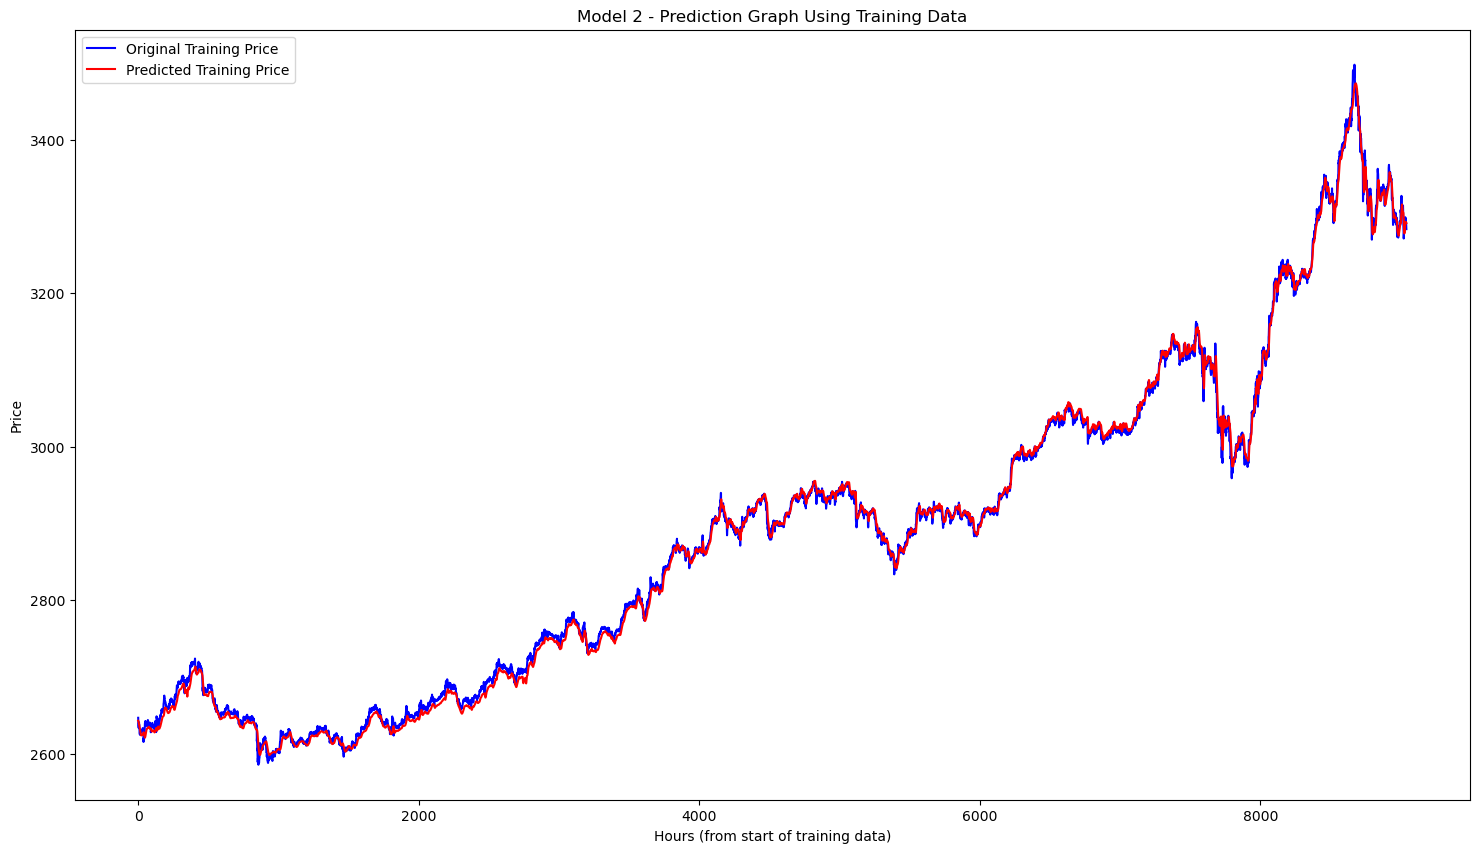

In [68]:
# Visualisasi Prediksi vs Aktual Model 2 (Training Data)
print("\nVisualisasi Prediksi vs Aktual Model 2 (Training Data):")
plt.figure(figsize=(18,10))
plt.plot(y_train_actual_m1, color = 'b', label = 'Original Training Price')
plt.plot(train_predict_m2_actual, color='red', label = 'Predicted Training Price')
plt.title("Model 2 - Prediction Graph Using Training Data")
plt.xlabel("Hours (from start of training data)")
plt.ylabel("Price")
plt.legend()
plt.show()


Visualisasi Prediksi vs Aktual Model 2 (Testing Data):


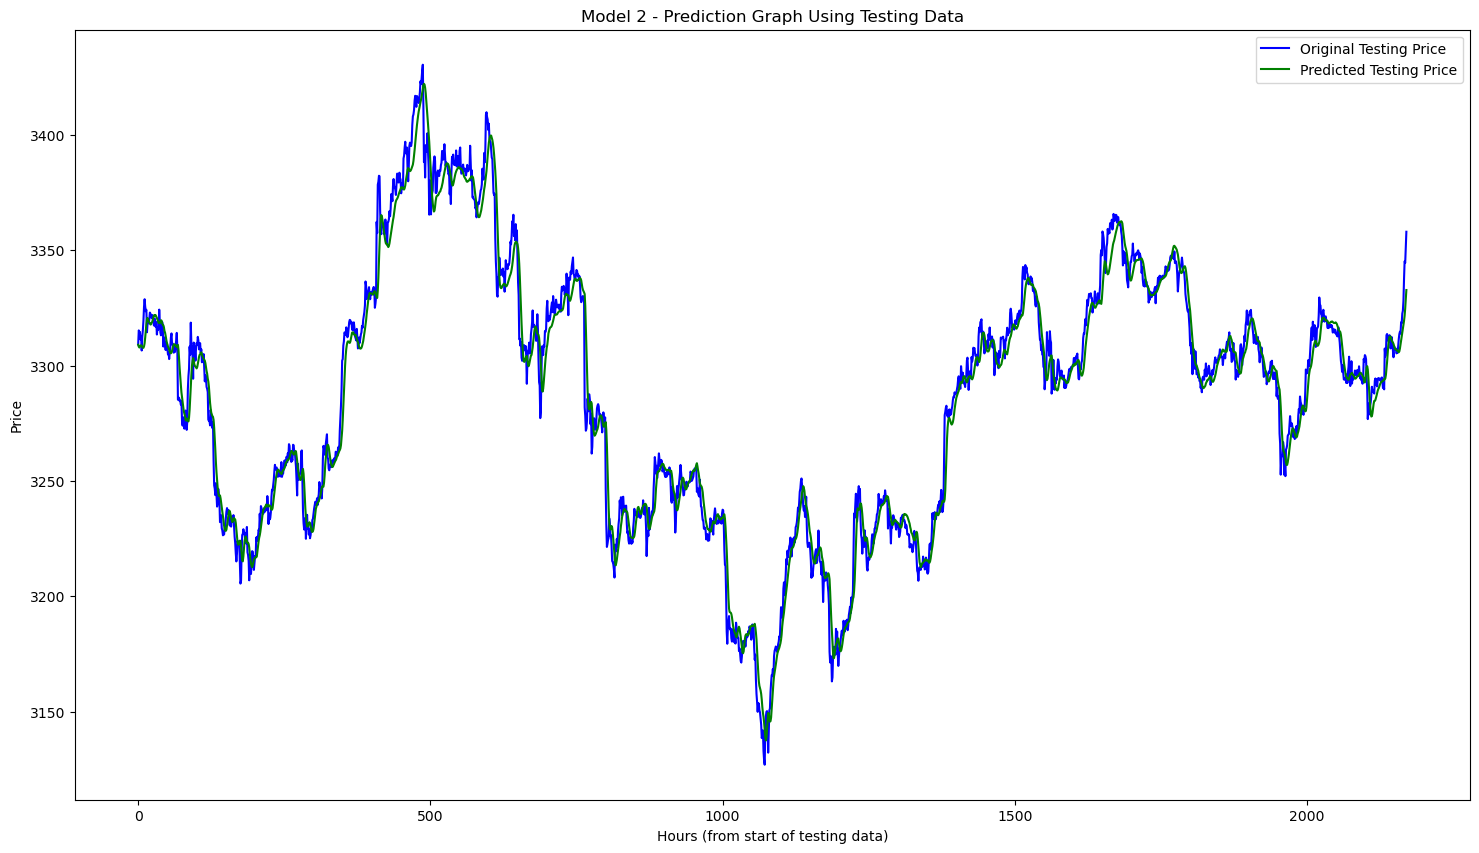

In [69]:
# Visualisasi Prediksi vs Aktual Model 2 (Testing Data)
print("\nVisualisasi Prediksi vs Aktual Model 2 (Testing Data):")
plt.figure(figsize=(18,10))
plt.plot(y_test_actual_m1, color = 'b', label = 'Original Testing Price')
plt.plot(test_predict_m2_actual, color='g', label = 'Predicted Testing Price')
plt.title("Model 2 - Prediction Graph Using Testing Data")
plt.xlabel("Hours (from start of testing data)")
plt.ylabel("Price")
plt.legend()
plt.show()

In [70]:
print("\n--- Training & Evaluation Kedua Model Selesai! 🎉 ---")


--- Training & Evaluation Kedua Model Selesai! 🎉 ---


# Model baru

In [71]:
# Asumsikan variabel seperti x_train, y_train, x_test, y_test, num_features,
# scaler_features, dan scaler_close sudah tersedia dari cell Preprocessing sebelumnya.
# Asumsikan library yang dibutuhkan sudah diimport di bagian Libraries (numpy, pandas, matplotlib, seaborn,
# tensorflow, keras.models.Sequential, keras.layers.LSTM, Dense, Dropout, Conv1D, MaxPooling1D,
# RootMeanSquaredError as rmse, EarlyStopping, ModelCheckpoint, K.clear_session, gc.collect, time).

print("\n--- 6. Model Training & Evaluation (Lanjutan) ---")

# --- Model 3 ---
print("\n## Model 3 (Simple Vanilla LSTM - Multivariate) - Training & Evaluation")

# Clear session dan set seed untuk reproduktifitas sebelum training Model 3
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
K.clear_session() # Membersihkan GPU memory
gc.collect() # Melakukan garbage collection
print("Session dan GPU memory telah dibersihkan untuk Model 3.")


--- 6. Model Training & Evaluation (Lanjutan) ---

## Model 3 (Simple Vanilla LSTM - Multivariate) - Training & Evaluation
Session dan GPU memory telah dibersihkan untuk Model 3.


In [72]:
# Definisikan arsitektur Model 3 (lebih sederhana)
model3 = Sequential()
model3.add(LSTM(30, return_sequences=True, input_shape=(x_train.shape[1], num_features))) # Unit lebih sedikit
model3.add(Dropout(0.5)) # Dropout lebih tinggi
model3.add(LSTM(30, return_sequences=False)) # Unit lebih sedikit
model3.add(Dropout(0.5)) # Dropout lebih tinggi
model3.add(Dense(units=1, activation='sigmoid')) # Output 1 unit dengan sigmoid
model3.compile(optimizer='adam', loss='mse', metrics=[rmse()]) # Compile dengan adam, mse, rmse
print("\nArsitektur Model 3 telah dibuat.")
model3.summary() # Tampilkan ringkasan model


Arsitektur Model 3 telah dibuat.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120, 30)           4440      
                                                                 
 dropout (Dropout)           (None, 120, 30)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 11,791
Trainable params: 11,791
Non-trainable params: 0
_________________________________________________________________


In [73]:
# Callback EarlyStopping untuk Model 3
early_stop_m3 = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Ukur waktu training Model 3
time_calc_start_m3 = time.time()

# Fit Model 3
print("\nMemulai training Model 3...")
history_m3 = model3.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=300, # Max 300 epochs, EarlyStopping akan menghentikan lebih awal
    batch_size=64, # Menggunakan batch_size 64 untuk Model 3
    callbacks=[early_stop_m3],
    verbose=1
)

fit_time_seconds_m3 = time.time() - time_calc_start_m3
print(f"\nFit time Model 3 = {fit_time_seconds_m3:.2f} seconds.")


Memulai training Model 3...
Epoch 1/300
142/142 [==============================] - 10s 42ms/step - loss: 0.0103 - root_mean_squared_error: 0.1013 - val_loss: 7.7770e-04 - val_root_mean_squared_error: 0.0279
Epoch 2/300
142/142 [==============================] - 5s 36ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415 - val_loss: 7.2175e-04 - val_root_mean_squared_error: 0.0269
Epoch 3/300
142/142 [==============================] - 5s 34ms/step - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 6.3945e-04 - val_root_mean_squared_error: 0.0253
Epoch 4/300
142/142 [==============================] - 5s 34ms/step - loss: 0.0013 - root_mean_squared_error: 0.0361 - val_loss: 2.9656e-04 - val_root_mean_squared_error: 0.0172
Epoch 5/300
142/142 [==============================] - 5s 35ms/step - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 6/300
142/142 [==============================] - 5s 35ms/step - loss: 0.0012 -


Visualisasi Loss Curve Model 3:


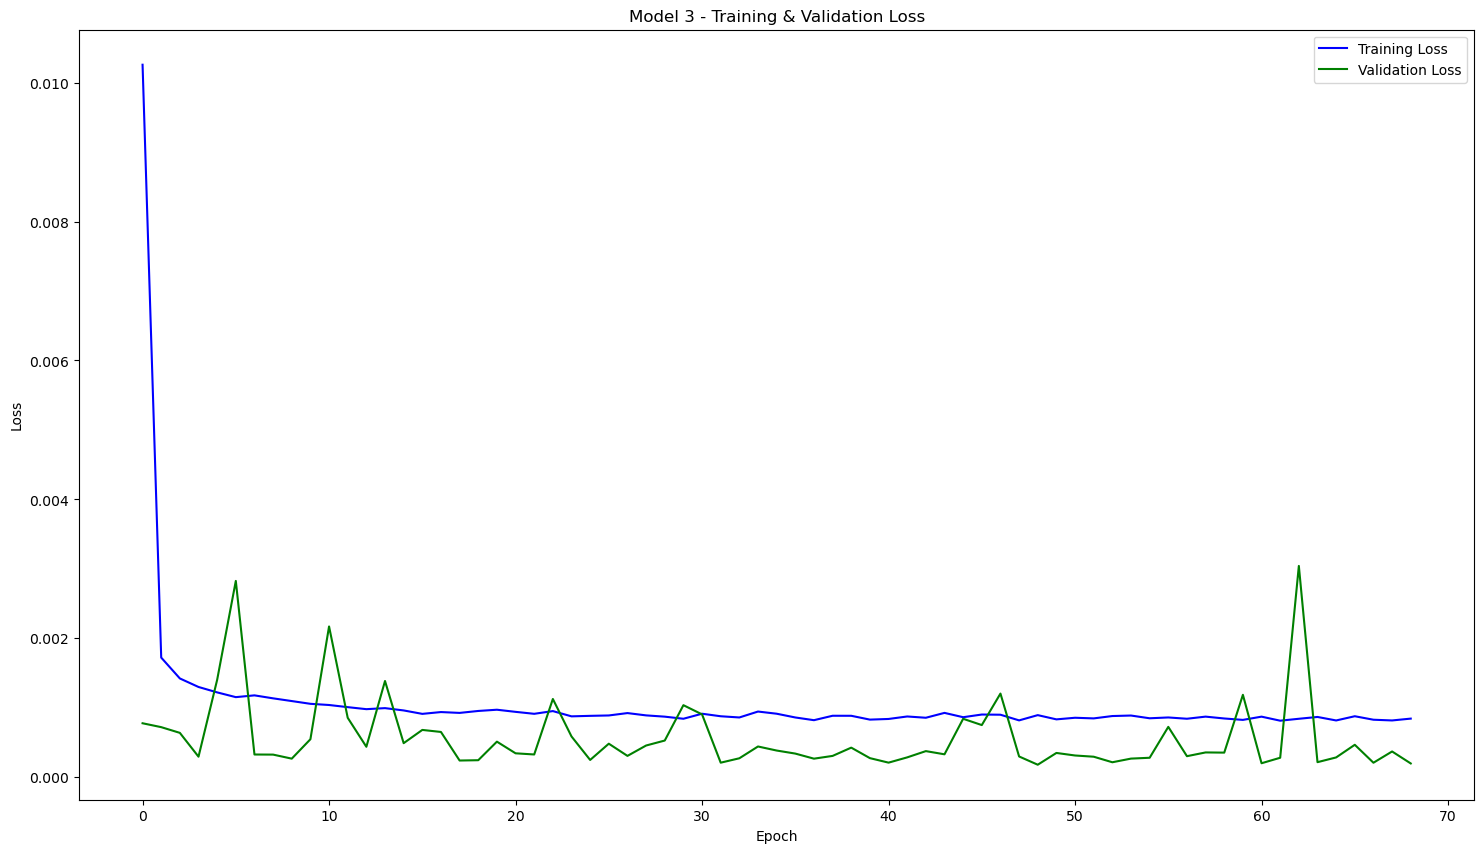

In [74]:
# Visualisasi Loss Curve Model 3
print("\nVisualisasi Loss Curve Model 3:")
plt.figure(figsize = (18,10))
plt.plot(history_m3.history['loss'],label='Training Loss',color='b')
plt.plot(history_m3.history['val_loss'],label='Validation Loss',color='g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model 3 - Training & Validation Loss")
plt.legend()
plt.show()

In [75]:

# Evaluasi Model 3
print("\nEvaluasi Model 3 pada data training:")
model3.evaluate(x_train, y_train, batch_size=32)


Evaluasi Model 3 pada data training:
283/283 [==============================] - 5s 17ms/step - loss: 8.3702e-05 - root_mean_squared_error: 0.0091


[8.370243449462578e-05, 0.00914890319108963]

In [76]:

print("\nEvaluasi Model 3 pada data testing:")
model3.evaluate(x_test, y_test, batch_size=32)


Evaluasi Model 3 pada data testing:
68/68 [==============================] - 1s 15ms/step - loss: 1.8085e-04 - root_mean_squared_error: 0.0134


[0.0001808484084904194, 0.013447988778352737]

In [77]:

# Prediksi dan Inverse Transform untuk Model 3
print("\nMelakukan prediksi dan Inverse Transform untuk Model 3...")
train_predict_m3_scaled = model3.predict(x_train)
test_predict_m3_scaled = model3.predict(x_test)


Melakukan prediksi dan Inverse Transform untuk Model 3...
68/68 [==============================] - 1s 14ms/step


In [78]:

# Inverse transform y_train dan y_test menggunakan scaler_close
# y_train_actual_m3 = scaler_close.inverse_transform(y_train.reshape(-1, 1)) # Sudah dihitung sebelumnya
# y_test_actual_m3 = scaler_close.inverse_transform(y_test.reshape(-1, 1))   # Sudah dihitung sebelumnya

train_predict_m3_actual = scaler_close.inverse_transform(train_predict_m3_scaled)
test_predict_m3_actual = scaler_close.inverse_transform(test_predict_m3_scaled)

In [79]:

# Hitung metrik Model 3
from sklearn import metrics
from sklearn.metrics import r2_score

rmse_train_m3 = np.sqrt(metrics.mean_squared_error(y_train_actual_m1, train_predict_m3_actual)) # y_train_actual_m1/y_test_actual_m1 dari Model 1/2
mse_train_m3 = metrics.mean_squared_error(y_train_actual_m1, train_predict_m3_actual)
r2_train_m3 = r2_score(y_train_actual_m1, train_predict_m3_actual)

rmse_test_m3 = np.sqrt(metrics.mean_squared_error(y_test_actual_m1, test_predict_m3_actual))
mse_test_m3 = metrics.mean_squared_error(y_test_actual_m1, test_predict_m3_actual)
r2_test_m3 = r2_score(y_test_actual_m1, test_predict_m3_actual)

In [80]:


print("\n--- Metrik Kinerja Model 3 ---")
print(f"Training RMSE: {rmse_train_m3:.4f}")
print(f"Training MSE : {mse_train_m3:.4f}")
print(f"Training R2  : {r2_train_m3:.4f}")
print(f"Testing RMSE : {rmse_test_m3:.4f}")
print(f"Testing MSE  : {mse_test_m3:.4f}")
print(f"Testing R2   : {r2_test_m3:.4f}")


--- Metrik Kinerja Model 3 ---
Training RMSE: 8.3397
Training MSE : 69.5506
Training R2  : 0.9984
Testing RMSE : 12.2585
Testing MSE  : 150.2718
Testing R2   : 0.9533



Visualisasi Prediksi vs Aktual Model 3 (Training Data):

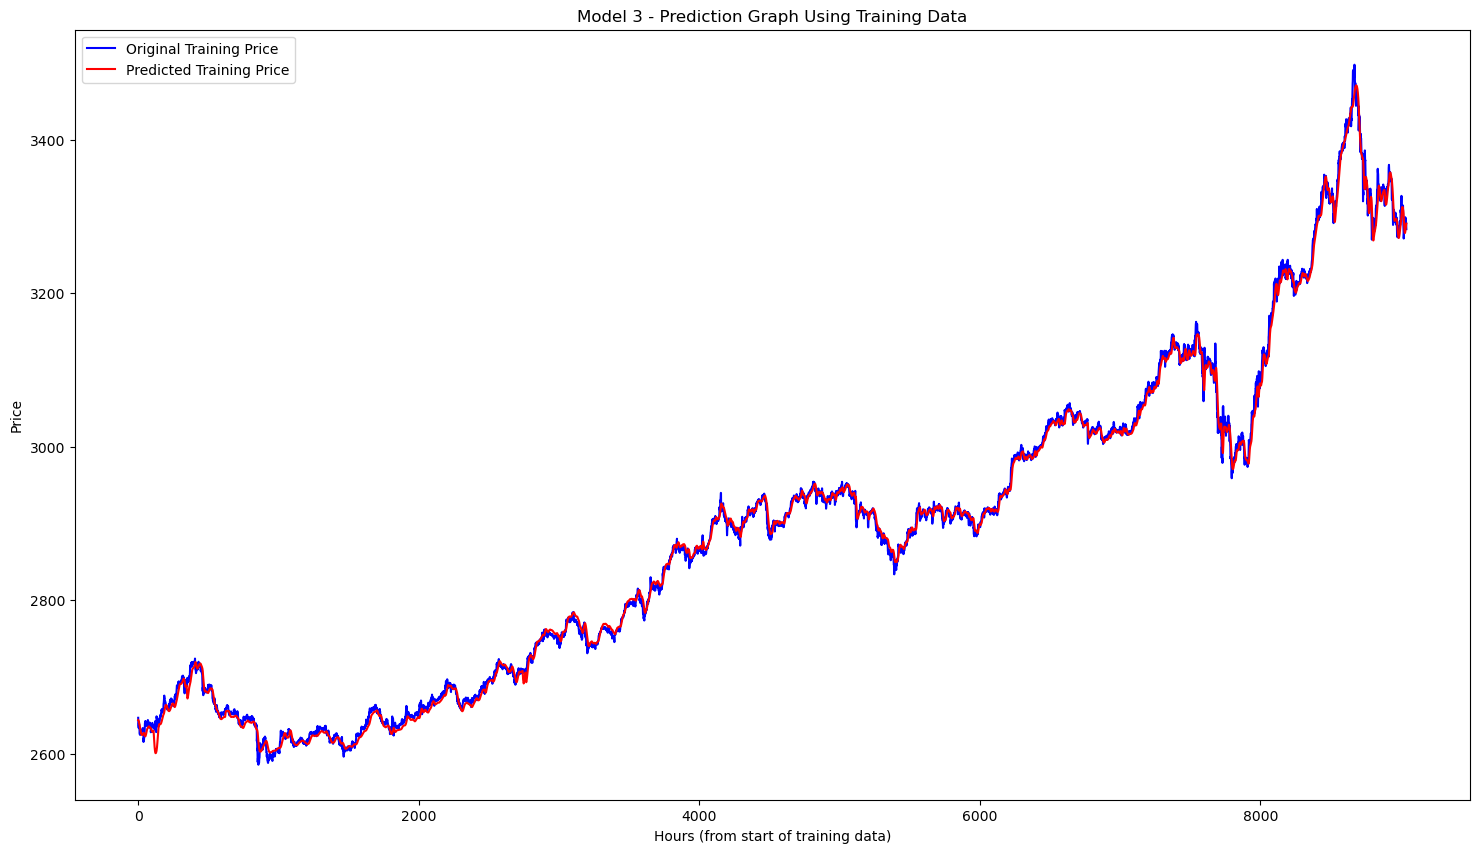

In [81]:

# Visualisasi Prediksi vs Aktual Model 3 (Training Data)
print("\nVisualisasi Prediksi vs Aktual Model 3 (Training Data):")
plt.figure(figsize=(18,10))
plt.plot(y_train_actual_m1, color = 'b', label = 'Original Training Price')
plt.plot(train_predict_m3_actual, color='red', label = 'Predicted Training Price')
plt.title("Model 3 - Prediction Graph Using Training Data")
plt.xlabel("Hours (from start of training data)")
plt.ylabel("Price")
plt.legend()
plt.show()


Visualisasi Prediksi vs Aktual Model 3 (Testing Data):


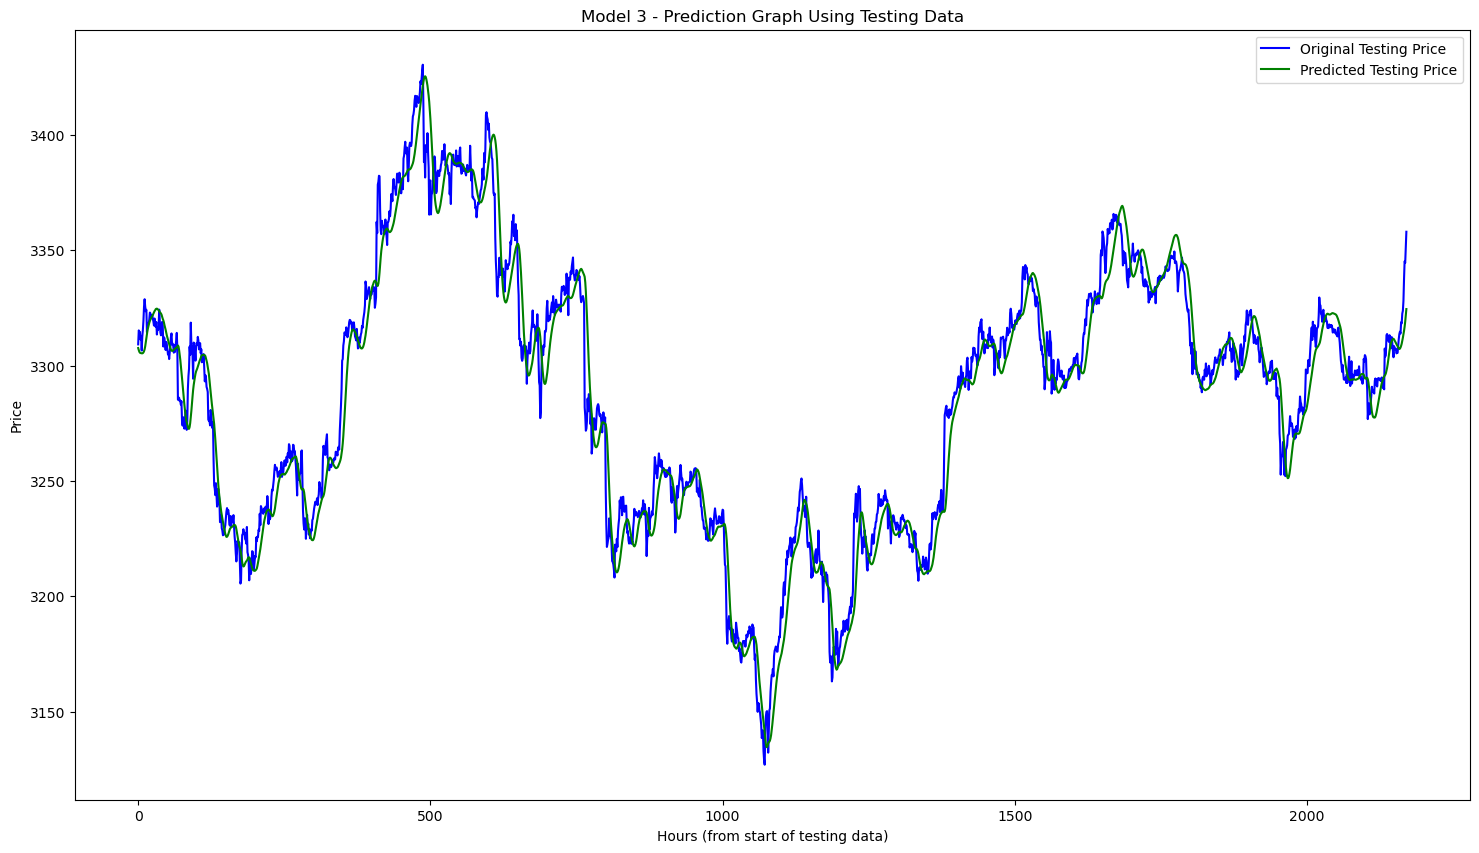

In [82]:

# Visualisasi Prediksi vs Aktual Model 3 (Testing Data)
print("\nVisualisasi Prediksi vs Aktual Model 3 (Testing Data):")
plt.figure(figsize=(18,10))
plt.plot(y_test_actual_m1, color = 'b', label = 'Original Testing Price')
plt.plot(test_predict_m3_actual, color='g', label = 'Predicted Testing Price')
plt.title("Model 3 - Prediction Graph Using Testing Data")
plt.xlabel("Hours (from start of testing data)")
plt.ylabel("Price")
plt.legend()
plt.show()

In [83]:
print("\n--- Training & Evaluation Model 3 Selesai! 🎉 ---")
# Jangan lupa mt5.shutdown() di akhir keseluruhan notebookmu
# mt5.shutdown()


--- Training & Evaluation Model 3 Selesai! 🎉 ---


In [84]:
# #calculate metrics
# from sklearn import metrics
# from sklearn.metrics import r2_score
# #transform data to real values
# value1=scaler.inverse_transform(plot_y_test)
# value2=scaler.inverse_transform(test_predict)
# #calc score
# score = np.sqrt(metrics.mean_squared_error(value1,value2))
# print("RMSE         : {}".format(score))
# print("MSE          :", metrics.mean_squared_error(value1,value2))
# print("R2 score     :",metrics.r2_score(value1,value2))

In [85]:
# #show actual vs predicted (testing) graph
# plt.figure(figsize=(18,10))
# plt.plot(scaler.inverse_transform(plot_y_test),color = 'b',  label = 'Original')
# plt.plot(scaler.inverse_transform(test_predict),color='g', label = 'Predicted')
# plt.title("Prediction Graph Using Testing Data")
# plt.xlabel("Hours")
# plt.ylabel("Price")
# plt.legend()
# plt.show()

In [86]:
# # save model to ONNX
# output_path = file_path+"model.xauusd.H1.120.onnx"
# onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)
# print(f"model saved to {output_path}")

# output_path = "model.xauusd.H1.120.onnx"
# onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)
# print(f"saved model to {output_path}")

# # finish
# mt5.shutdown()

## Model 2

In [87]:
# #show iteration-loss graph for training and validation
# plt.figure(figsize = (18,10))
# plt.plot(history.history['loss'],label='Training Loss',color='b')
# plt.plot(history.history['val_loss'],label='Validation-loss',color='g')
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.title("LOSS")
# plt.legend()

In [88]:
# #evaluate training data
# model.evaluate(x_train,y_train, batch_size = 32)

In [89]:
# #evaluate testing data
# model.evaluate(x_test,y_test, batch_size = 32)

In [90]:
# #prediction using training data
# train_predict = model.predict(x_train)
# plot_y_train = y_train.reshape(-1,1)

In [91]:
# #show actual vs predicted (training) graph
# plt.figure(figsize=(18,10))
# plt.plot(scaler.inverse_transform(plot_y_train),color = 'b', label = 'Original')
# plt.plot(scaler.inverse_transform(train_predict),color='red', label = 'Predicted')
# plt.title("Prediction Graph Using Training Data")
# plt.xlabel("Hours")
# plt.ylabel("Price")
# plt.legend()
# plt.show()

In [92]:
# #prediction using testing data
# test_predict = model.predict(x_test)
# plot_y_test = y_test.reshape(-1,1)

In [93]:
# #calculate metrics
# from sklearn import metrics
# from sklearn.metrics import r2_score
# #transform data to real values
# value1=scaler.inverse_transform(plot_y_test)
# value2=scaler.inverse_transform(test_predict)
# #calc score
# score = np.sqrt(metrics.mean_squared_error(value1,value2))
# print("RMSE         : {}".format(score))
# print("MSE          :", metrics.mean_squared_error(value1,value2))
# print("R2 score     :",metrics.r2_score(value1,value2))

In [94]:
# #show actual vs predicted (testing) graph
# plt.figure(figsize=(18,10))
# plt.plot(scaler.inverse_transform(plot_y_test),color = 'b',  label = 'Original')
# plt.plot(scaler.inverse_transform(test_predict),color='g', label = 'Predicted')
# plt.title("Prediction Graph Using Testing Data")
# plt.xlabel("Hours")
# plt.ylabel("Price")
# plt.legend()
# plt.show()